# Gender disparities in child custody sentencing in Spain <a class="tocSkip">

**Legend** <br>
<div class="alert alert-block col-md-7 alert-info">Question</div>
<div class="alert alert-block col-md-7 alert-warning">Partial conclusions</div> 
<div class="alert alert-block col-md-7 alert-success">Conclusion</div>

**Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import json

# Utils
import modules.utils.utils as utils

# Data preparation
import modules.data_preparation.sentence_scrapping as sentence_scrapping
import modules.data_preparation.dataset_extension as dataset_extension
import modules.data_preparation.categories as categories

# Exploratory data analysis
import modules.exploratory_data_analysis.base_rates as base_rates
import modules.exploratory_data_analysis.statistical_analysis as statistical_analysis

# Data wrangling
import modules.data_wrangling.feature_selection as feature_selection
import modules.data_wrangling.data_wrangling as data_wrangling

# Sentence similarity
import modules.sentence_similarity.visualizations_with_pca as visualizations_with_pca
import modules.sentence_similarity.distances as distances
import modules.sentence_similarity.counterfactual.distances as distances_counterfactual
import modules.sentence_similarity.counterfactual.differences as differences
import modules.sentence_similarity.data_separability.data_separability as data_separability

# Classifiers
import modules.classification.classifiers as classifiers
import modules.classification.classifiers_comparison as classifiers_comparison
import modules.classification.disparity_score as disparity_score
import modules.classification.disparity_score_by_category as disparity_score_by_category
import modules.classification.probabilities as probabilities

# Propensity score
import modules.propensity_score.propensity_score as propensity_score
import modules.propensity_score.table_propensity_score_gender_effect as table_propensity_score_gender_effect

# Exact matching
import modules.exact_matching.get_pairs as get_pairs
import modules.exact_matching.get_distances as get_distances
import modules.exact_matching.precomputations as precomputations
import modules.exact_matching.gender_effect as gender_effect


import warnings
warnings.filterwarnings('ignore')

# Dataset description

The [dataset](https://github.com/labje/bidaraciv) used is the result of the project “Análisis mediante Big Data de la argumentación jurídica contenida en las resoluciones de la jurisdicción civil en Aragón”. [More information](https://www.youtube.com/watch?v=zrXOLBzetys).

In [2]:
df_original = pd.read_csv("..\data\BIDARACIV_Predict-Court-Decision_Data.csv", sep=";")

In [3]:
df_original.head()

,DATE,YEAR,Train,ID,URL,PLAIN_ML,PLAIN_WO,DEFEN_ML,RQ_JOINT,PCI+,...,FT_AG_b,FT_AG,LN_JNPREF_b,LN_JNPREF,FT_SL_IN_b,FT_JN_IN_b,FT_SL_IN,FT_JN_IN,JUDGE_ML,Unnamed: 113
0,43362,2018,1,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,1,0,0,1,0,...,0,0,0,0,3,2,5,4,1,NaN
1,43621,2019,0,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,1,0,0,1,0,...,0,0,0,0,1,1,1,3,1,NaN
2,43607,2019,0,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,1,0,0,1,0,...,0,0,0,0,4,3,8,6,1,NaN
3,43600,2019,0,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,1,0,0,1,0,...,0,0,0,0,2,1,3,2,0,NaN
4,43818,2019,0,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,1,0,0,1,0,...,0,0,0,0,2,0,3,0,1,NaN


In [4]:
df_original.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 114 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          1884 non-null   int64  
 1   YEAR          1884 non-null   int64  
 2   Train         1884 non-null   int64  
 3   ID            1884 non-null   object 
 4   URL           1884 non-null   object 
 5   PLAIN_ML      1884 non-null   int64  
 6   PLAIN_WO      1884 non-null   int64  
 7   DEFEN_ML      1884 non-null   int64  
 8   RQ_JOINT      1884 non-null   int64  
 9   PCI+          1884 non-null   int64  
 10  PCI-          1881 non-null   float64
 11  RQ_FH_AT      1884 non-null   int64  
 12  RQ_FH_SP      1884 non-null   int64  
 13  PVF+          1884 non-null   int64  
 14  PVF-          1884 non-null   int64  
 15  RQ_MP_AT      1884 non-null   int64  
 16  RQ_MP_SP      1884 non-null   int64  
 17  PPA+          1884 non-null   int64  
 18  PPA-          1884 non-null

In [5]:
df = df_original

# Data preparation 

## Categories dataset

In [6]:
df_categories = categories.get_df_categories()
df_categories.head()

,feature,category
0,LP_BI_b,Legal principles (general)
1,LP_BI,Legal principles (general)
2,LP_BI_SL_b,Legal principles (general)
3,LP_BI_SL,Legal principles (general)
4,LP_BI_JN_b,Legal principles (general)


In [7]:
df_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   feature   74 non-null     object
 1   category  74 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [8]:
list_categories = categories.get_list_categories()
list_categories

['Legal principles (general)',
 'Economical aspects',
 'Procesal (economia del procedimiento)',
 'Personal circumstances (parents, children)',
 'Subjectivity (children)',
 'Personal circumstances (children)',
 'Subjectivity (parents)',
 'Legal principles (particular)']

## Dataset extension

### Sentence scrapping

In [9]:
#judge_name_list, headquarters_list = sentence_scrapping.get_sentence_info(df)

### Column extension

In [10]:
added_features_list = ["HQ", "AUT_COMM","JUDGE_ID"]

#### Add judge id column 

In [11]:
#judge_id_list = dataset_extension.create_judge_id_list(judge_name_list, debug = True)

In [12]:
#dataset_extension.insert_column(df, "JUDGE_ML", "JUDGE_ID", judge_id_list)

#### Add headquarters column

In [13]:
#dataset_extension.insert_column(df, "URL", "HQ", headquarters_list)

In [14]:
#df = dataset_extension.standarize_headquarters_names(df)

#### Add autonomous community column

In [15]:
#df = dataset_extension.add_autonomous_community(df)

### Save and open new dataset

In [16]:
#df.to_excel("..\output\extended_dataset.xlsx")  

In [17]:
#df.to_csv("..\output\extended_dataset.csv", sep=";", index=False)

In [18]:
df = pd.read_csv("..\output\extended_dataset.csv", sep=";")
df.head()

,DATE,YEAR,Train,ID,URL,HQ,AUT_COMM,PLAIN_ML,PLAIN_WO,DEFEN_ML,...,FT_AG,LN_JNPREF_b,LN_JNPREF,FT_SL_IN_b,FT_JN_IN_b,FT_SL_IN,FT_JN_IN,JUDGE_ML,JUDGE_ID,Unnamed: 113
0,43362,2018,1,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,Alicante,Comunidad Valenciana,1,0,0,...,0,0,0,3,2,5,4,1,0,NaN
1,43621,2019,0,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,Alicante,Comunidad Valenciana,1,0,0,...,0,0,0,1,1,1,3,1,1,NaN
2,43607,2019,0,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,Alicante,Comunidad Valenciana,1,0,0,...,0,0,0,4,3,8,6,1,1,NaN
3,43600,2019,0,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,Alicante,Comunidad Valenciana,1,0,0,...,0,0,0,2,1,3,2,0,2,NaN
4,43818,2019,0,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,Barcelona,Cataluña,1,0,0,...,0,0,0,2,0,3,0,1,3,NaN


In [19]:
Counter(df["AUT_COMM"]).most_common()

[('Cataluña', 321),
 ('Andalucía', 255),
 ('Castilla y León', 250),
 ('Comunidad de Madrid', 224),
 ('Comunidad Valenciana', 147),
 ('Castilla-La Mancha', 82),
 ('Galicia', 81),
 ('Islas Baleares', 74),
 ('Asturias', 70),
 ('País Vasco', 69),
 ('Aragón', 69),
 ('Región de Murcia', 52),
 ('Navarra', 43),
 ('Extremadura', 42),
 ('Cantabria', 30),
 ('Castilla - La Mancha', 27),
 ('Canarias', 27),
 ('La Rioja', 14),
 ('Galícia', 4),
 ('Melilla', 3)]

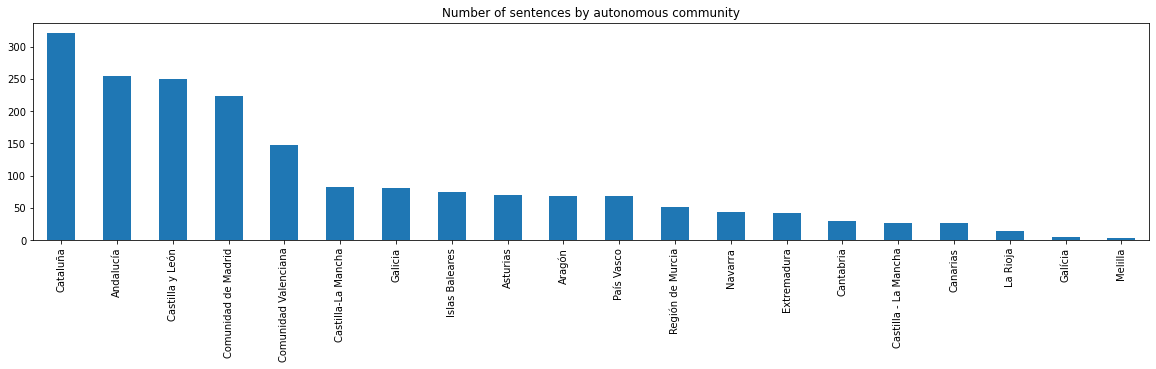

In [20]:
fig = plt.figure(figsize=(20,4))
df["AUT_COMM"].value_counts(sort=True).plot.bar()
plt.title("Number of sentences by autonomous community")
plt.show()

In [21]:
Counter(df["JUDGE_ID"]).most_common()

[(31, 38),
 (152, 31),
 (3, 29),
 (101, 29),
 (30, 25),
 (147, 25),
 (148, 25),
 (151, 25),
 (27, 24),
 (23, 23),
 (153, 23),
 (264, 23),
 (21, 21),
 (159, 21),
 (118, 20),
 (29, 19),
 (19, 18),
 (46, 18),
 (246, 18),
 (244, 17),
 (251, 17),
 (282, 17),
 (26, 16),
 (67, 16),
 (102, 16),
 (284, 16),
 (287, 16),
 (156, 15),
 (306, 15),
 (307, 15),
 (1, 14),
 (119, 14),
 (120, 14),
 (267, 14),
 (285, 14),
 (22, 13),
 (66, 13),
 (243, 13),
 (245, 13),
 (289, 13),
 (186, 12),
 (272, 12),
 (288, 12),
 (10, 11),
 (32, 11),
 (150, 11),
 (230, 11),
 (293, 11),
 (309, 11),
 (115, 10),
 (123, 10),
 (178, 10),
 (179, 10),
 (235, 10),
 (266, 10),
 (0, 9),
 (17, 9),
 (25, 9),
 (42, 9),
 (44, 9),
 (79, 9),
 (161, 9),
 (184, 9),
 (187, 9),
 (273, 9),
 (292, 9),
 (310, 9),
 (9, 8),
 (11, 8),
 (33, 8),
 (48, 8),
 (49, 8),
 (77, 8),
 (85, 8),
 (103, 8),
 (155, 8),
 (181, 8),
 (239, 8),
 (247, 8),
 (249, 8),
 (2, 7),
 (43, 7),
 (73, 7),
 (76, 7),
 (78, 7),
 (82, 7),
 (104, 7),
 (130, 7),
 (194, 7),
 (198,

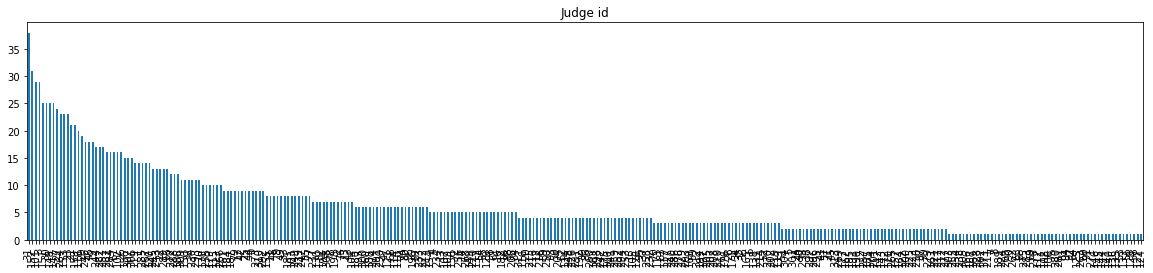

In [22]:
fig = plt.figure(figsize=(20,4))
df["JUDGE_ID"].value_counts(sort=True).plot.bar()
plt.title("Judge id")
plt.show()

# Exploratory data analysis

## Plaintiffs gender

The plaintiff gender is embeded in the PLAIN_ML attribute which is 0 for female and 1 for male. We also have the PLAIN_WO attribute, which tells the opposite.

Counter({1: 1131, 0: 753})


Female plaintiff: 39.97%
Male plaintiff: 60.03%




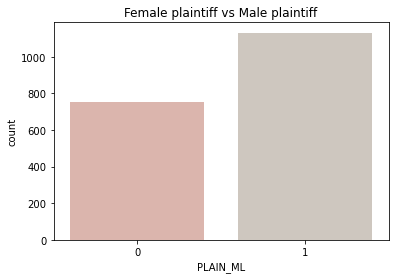

In [23]:
base_rates.percentages(df, "PLAIN_ML", "Female plaintiff", "Male plaintiff")

<div class="alert alert-block alert-warning col-md-12">

<p>
There are 1131 rows with male plaintiffs and 753 with female plaintiffs in the dataset. This means that 60.03% of the plaintiffs are males and 39.97% are females.
</p>

</div>

### Same gender parents

In [24]:
same_gender_df = df[df['PLAIN_ML'] == df["DEFEN_ML"]]
print("Plaintiff wins: ",len(same_gender_df[same_gender_df['WINWIN']==1]))
same_gender_df

Plaintiff wins:  0


,DATE,YEAR,Train,ID,URL,HQ,AUT_COMM,PLAIN_ML,PLAIN_WO,DEFEN_ML,...,FT_AG,LN_JNPREF_b,LN_JNPREF,FT_SL_IN_b,FT_JN_IN_b,FT_SL_IN,FT_JN_IN,JUDGE_ML,JUDGE_ID,Unnamed: 113
1086,43495,2019,1,APM_2019_980,http://labje.unizar.es/sentencias/APM_2019_980...,Madrid,Comunidad de Madrid,0,1,0,...,0,0,0,0,4,0,13,0,155,NaN
1711,43781,2019,0,APV_2019_4575,http://labje.unizar.es/sentencias/APV_2019_457...,Valencia,Comunidad Valenciana,0,1,0,...,-1,0,0,2,4,3,10,1,284,NaN
1836,43745,2019,0,APZ_2019_2314,http://labje.unizar.es/sentencias/APZ_2019_231...,Zaragoza,Aragón,0,1,0,...,0,0,0,5,1,8,1,1,306,NaN


<div class="alert alert-block alert-warning col-md-12">

<p>
There are only three rows in the dataset with same gender parents. All three correspont to female plaintiff and defendant. None of the three plaintiffs win.
</p>

</div>

## Judges gender

The judge gender is embeded in the JUDGE_ML attribute which is 0 for female and 1 for male.

Counter({1: 1194, 0: 690})


Female judges: 36.62%
Male judges: 63.38%




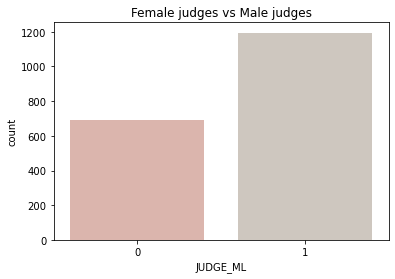

In [25]:
base_rates.percentages(df, "JUDGE_ML", "Female judges", "Male judges")

<div class="alert alert-block alert-warning col-md-12">

<p>
There are 1194 rows with male judges and 690 with female judges in the dataset. This means that 63.38% of the judges are males and 36.62% are females.
</p>

</div>

## Victory rates

The WINWIN attribute corresponds to the court decision with respect to the sole/joint custody request. Is is 1 when the court decides sole custody or joint custody as the plaintiff has requested, and 0 if it decides the opposite as the plaintiff requested.

Counter({0: 1549, 1: 335})


Plaintiff loses: 82.22%
Plaintiff wins: 17.78%




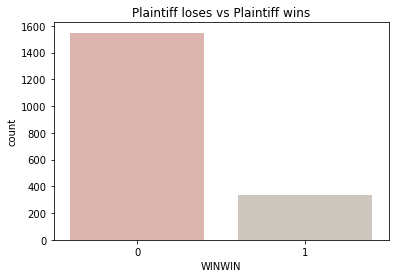

In [26]:
base_rates.percentages(df, "WINWIN", "Plaintiff loses", "Plaintiff wins")

<div class="alert alert-block alert-warning col-md-12">

<p>
There are 1549 rows where the decision of the court is the opposite as the plaintiff request and 335 where the plaintiff wins. Meaning an 82.22% and 17.78% distribution.<br>
</p>

</div>

### Victory rates by plaintiff gender

In [27]:
base_rates.percentages_by_group(df, "WINWIN", "PLAIN_ML", "Female plaintiff wins", "Male plaintiff win", zero_case = True, group_1_zero = "Female plaintiff loses", group_2_zero = "Male plaintiff loses")

PLAIN_ML = 0 -->  WINWIN: Counter({0: 645, 1: 108})

Female plaintiff loses: 85.66%
Female plaintiff wins: 14.34%

PLAIN_ML = 1 -->  WINWIN: Counter({0: 904, 1: 227})

Male plaintiff loses: 79.93%
Male plaintiff win: 20.07%


In [28]:
base_rates.ratio_by_group(df, "WINWIN", "PLAIN_ML", "Female", "Male")

WINWIN = 0 -->  Ratio between Female/Male is: 1.07
WINWIN = 1 -->  Ratio between Female/Male is: 0.71


In [29]:
statistical_analysis.t_test(df, "WINWIN", "PLAIN_ML")

Unpaired/independent t-test to determine if there is significant difference between the two groups by quantifying the difference between the arithmetic means 

------> T-statistic: -3.192080991568677

------> p-value: 0.0014358301123764507

Since p-value is smaller than alpha, we REJECT the null hypothesis H0. Thus, there is a significant difference between both groups


<div class="alert alert-block alert-warning col-md-12">

<p>
We can observe that males have more chances to win than females in this dataset. 
</p>

</div>

### Victory rates by judge gender

In [30]:
base_rates.percentages_by_group(df, "WINWIN", "JUDGE_ML", "Plaintiff wins with female judges", "Plaintiff wins with male judges", zero_case = True, group_1_zero = "Plaintiff loses with female judges", group_2_zero = "Plaintiff loses with male judges")

JUDGE_ML = 0 -->  WINWIN: Counter({0: 548, 1: 142})

Plaintiff loses with female judges: 79.42%
Plaintiff wins with female judges: 20.58%

JUDGE_ML = 1 -->  WINWIN: Counter({0: 1001, 1: 193})

Plaintiff loses with male judges: 83.84%
Plaintiff wins with male judges: 16.16%


In [31]:
base_rates.ratio_by_group(df, "WINWIN", "JUDGE_ML", "Female", "Male")

WINWIN = 0 -->  Ratio between Female/Male is: 0.95
WINWIN = 1 -->  Ratio between Female/Male is: 1.27


In [32]:
statistical_analysis.t_test(df, "WINWIN", "JUDGE_ML")

Unpaired/independent t-test to determine if there is significant difference between the two groups by quantifying the difference between the arithmetic means 

------> T-statistic: 2.417391687696814

------> p-value: 0.015726678996742405

Since p-value is smaller than alpha, we REJECT the null hypothesis H0. Thus, there is a significant difference between both groups


<div class="alert alert-block alert-warning col-md-12">

<p>
We can observe that female judges tend to be more involved in cases where the plaintiff wins.
</p>

</div>

### Victory rates by gender

In [33]:
base_rates.percentages_cross_groups(df, "WINWIN", "PLAIN_ML", "JUDGE_ML", "female plaintiff", "male plaintiff", "female judge", "male judge")

WINWIN percentage for female plaintiff, female judge --> 16.97%
WINWIN percentage for female plaintiff, male judge --> 12.86%
WINWIN percentage for male plaintiff, female judge --> 22.91%
WINWIN percentage for male plaintiff, male judge --> 18.4%


<div class="alert alert-block alert-warning col-md-12">

<p>
With both plaintiff genders if the judge is a female plaintiffs are more likely to than if the judge is a male. Also males are more likely to win, with both judge genders.<br><br>
    
It does not seem a priori that female judges favor female plaintiffs and male judges favor male plaintiffs. Neither the opposite. <br>
</p>

</div>

## Request nature (sole vs joint)

One of the request attributes is the RQ_JOINT attribute. It is 1 if the plaintiff requests joint custody and 0 if sole custody is requested. 

Counter({1: 1031, 0: 853})


Sole custody request: 45.28%
Join custody request: 54.72%




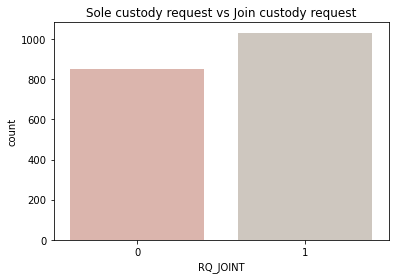

In [34]:
base_rates.percentages(df, "RQ_JOINT", "Sole custody request", "Join custody request")

<div class="alert alert-block alert-warning col-md-12">

<p>
There are 1031 (54.81%) joint custody requests and 850 (45.19%) sole custody requests in the dataset. The data is quite balanced in this sense. <br>
</p>

</div>

### Request nature by plaintiff gender

PLAIN_ML = 0 -->  RQ_JOINT: Counter({0: 651, 1: 102})

Sole custody request by females: 86.45%
Join custody request by females: 13.55%


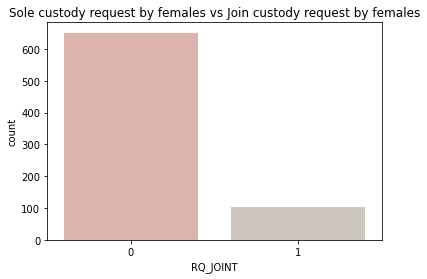


PLAIN_ML = 1 -->  RQ_JOINT: Counter({1: 929, 0: 202})

Sole custody request by males: 17.86%
Join custody request by males: 82.14%


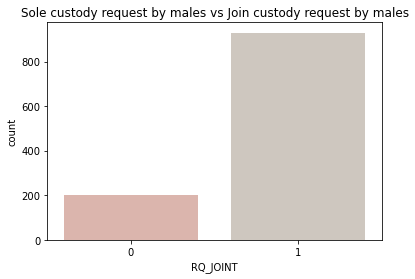

In [35]:
base_rates.percentages_by_group(df, "RQ_JOINT", "PLAIN_ML", "Join custody request by females", "Join custody request by males", zero_case = True, group_1_zero = "Sole custody request by females", group_2_zero = "Sole custody request by males", plot = True)

<div class="alert alert-block alert-warning col-md-12">

<p>
We can clearly observe that females tend to ask more for sole custody (86.45%) and males tend to ask more for joint custody (82.14%).<br><br>
    
Taking into account this percentages, and that joint custody win percentage is higher (21.34%, versus the 13.53% for sole custody). An hypothesis may be that this is the reason, or one of the reasons, why males have a higher winning percentage (20.07%, versus the 14.34% for female plaintiffs).    

</p>

</div>

### Request nature by judge gender

JUDGE_ML = 0 -->  RQ_JOINT: Counter({1: 379, 0: 311})

Sole custody request with female judge: 45.07%
Join custody request with female judge: 54.93%


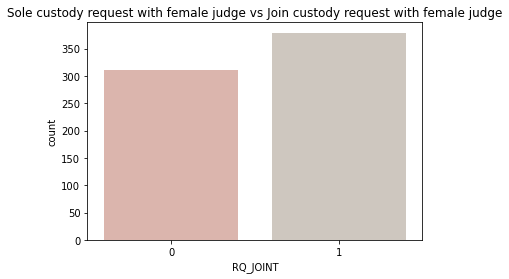


JUDGE_ML = 1 -->  RQ_JOINT: Counter({1: 652, 0: 542})

Sole custody request with male judge: 45.39%
Join custody request with male judge: 54.61%


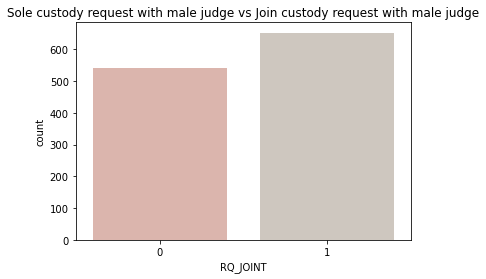

In [36]:
base_rates.percentages_by_group(df, "RQ_JOINT", "JUDGE_ML", "Join custody request with female judge", "Join custody request with male judge", zero_case = True, group_1_zero = "Sole custody request with female judge", group_2_zero = "Sole custody request with male judge", plot = True)

<div class="alert alert-block alert-warning col-md-12">

<p>
We can observe that in both cases the percentage of sole and joint custody sentences is balanced. And that there is no diference in the percentages between female and male judges.<br>
</p>

</div>

## Request nature victory rates

In [37]:
base_rates.percentages_by_group(df, "WINWIN", "RQ_JOINT", "Sole custody win percentage", "Joint custody win percentage")

RQ_JOINT = 0 -->  WINWIN: Counter({0: 738, 1: 115})

Sole custody win percentage: 13.48%

RQ_JOINT = 1 -->  WINWIN: Counter({0: 811, 1: 220})

Joint custody win percentage: 21.34%


<div class="alert alert-block alert-warning col-md-12">

<p>
13.53% of the cases were the plaintiff requests for sole custody are won and 21.34% of the cases where the plaintiff asks for joint custody are won. Thus, joint custody requests are more likely to be won.
</p>

</div>

### Request nature victory rates by plaintiff gender

In [38]:
base_rates.percentages_cross_groups(df, "WINWIN", "PLAIN_ML", "RQ_JOINT", "female plaintiff", "male plaintiff", "sole custody", "joint custody")

WINWIN percentage for female plaintiff, sole custody --> 14.13%
WINWIN percentage for female plaintiff, joint custody --> 15.69%
WINWIN percentage for male plaintiff, sole custody --> 11.39%
WINWIN percentage for male plaintiff, joint custody --> 21.96%


<div class="alert alert-block alert-warning col-md-12">

<p>
Females have aproximately same chances to win sole or joint custody. Males have less chances to win sole custody than females and more chances to win joint custody than females.
</p>

</div>

### Request nature victory rates by judge gender

In [39]:
base_rates.percentages_cross_groups(df, "WINWIN", "JUDGE_ML", "RQ_JOINT", "female judge", "male judge", "sole custody", "joint custody")

WINWIN percentage for female judge, sole custody --> 16.72%
WINWIN percentage for female judge, joint custody --> 23.75%
WINWIN percentage for male judge, sole custody --> 11.62%
WINWIN percentage for male judge, joint custody --> 19.94%


<div class="alert alert-block alert-warning col-md-12">

<p>
Both female and male judges are more involved in joint custody winning cases than in sole custody winning cases. Also, there is more difference between joint and sole winning percentage in sentences handed down by male judges.
</p>

</div>

## Other base rates

### Maintenance payments request (attribution and suppression)

In [40]:
base_rates.percentages_by_group(df, "RQ_MP_AT", "PLAIN_ML", "Female plaintiff asks for maintenance payments attribution", "Male plaintiff asks for maintenance payments attribution")

PLAIN_ML = 0 -->  RQ_MP_AT: Counter({0: 473, 1: 280})

Female plaintiff asks for maintenance payments attribution: 37.18%

PLAIN_ML = 1 -->  RQ_MP_AT: Counter({0: 1047, 1: 84})

Male plaintiff asks for maintenance payments attribution: 7.43%


In [41]:
base_rates.percentages_by_group(df, "RQ_MP_SP", "PLAIN_ML", "Female plaintiff asks for maintenance payments suppression", "Male plaintiff asks for maintenance payments suppression")

PLAIN_ML = 0 -->  RQ_MP_SP: Counter({0: 654, 1: 99})

Female plaintiff asks for maintenance payments suppression: 13.15%

PLAIN_ML = 1 -->  RQ_MP_SP: Counter({1: 604, 0: 527})

Male plaintiff asks for maintenance payments suppression: 53.4%


<div class="alert alert-block alert-warning col-md-12">

<p>
The percentages between female and male plaintiffs when asking for the attribution or the suppression of maintenance payments are highly imbalanced. Females tend to ask much more than males for the attribution and males tend to ask much more than females for their suppression.</p>

</div>

### Family home request (attribution and suppression)

In [42]:
base_rates.percentages_by_group(df, "RQ_FH_AT", "PLAIN_ML", "Female plaintiff asks for family home attribution", "Male plaintiff asks for family home attribution")

PLAIN_ML = 0 -->  RQ_FH_AT: Counter({0: 666, 1: 87})

Female plaintiff asks for family home attribution: 11.55%

PLAIN_ML = 1 -->  RQ_FH_AT: Counter({0: 1039, 1: 92})

Male plaintiff asks for family home attribution: 8.13%


In [43]:
base_rates.percentages_by_group(df, "RQ_FH_SP", "PLAIN_ML", "Female plaintiff asks for family home suppression", "Male plaintiff asks for family home suppression")

PLAIN_ML = 0 -->  RQ_FH_SP: Counter({0: 744, 1: 9})

Female plaintiff asks for family home suppression: 1.2%

PLAIN_ML = 1 -->  RQ_FH_SP: Counter({0: 1066, 1: 65})

Male plaintiff asks for family home suppression: 5.75%


<div class="alert alert-block alert-warning col-md-12">

<p>
For the family home attribution or suppression request, we can see the same pattern as in the maintenance payments request, although the differences are not that extreme.</p>

</div>

# Data wrangling

## Feature selection

In [44]:
features_classification_lists = feature_selection.features_classification_lists()
features_classification_lists

Group
Court decisions            [CD_JOINT, CD_JO_CF, WIN_SL, WINWIN, CD_FH_AT,...
Defendants's gender                                               [DEFEN_ML]
Facts                      [FT_RP_b, FT_RP, FT_CW_b, FT_CW, FT_CC_b, FT_C...
Facts detail               [FT_RP_SL_b, FT_RP_SL, FT_RP_JN_b, FT_RP_JN, F...
Facts index                     [FT_SL_IN_b, FT_JN_IN_b, FT_SL_IN, FT_JN_IN]
Judge gender                                                      [JUDGE_ML]
Judicial resolution                                    [ID, URL, DATE, YEAR]
Legal norms                                         [LN_JNPREF_b, LN_JNPREF]
Legal principles           [LP_BI_b, LP_BI, LP_PE_b, LP_PE, LP_RA_b, LP_R...
Legal principles detail    [LP_BI_SL_b, LP_BI_SL, LP_BI_JN_b, LP_BI_JN, L...
Plainfiff's gender                                                [PLAIN_ML]
Plainfiff's requests       [RQ_JOINT, RQ_FH_AT, RQ_FH_SP, RQ_MP_AT, RQ_MP...
Name: Short name, dtype: object

In [45]:
df = feature_selection.select_dataset_features(df, features_classification_lists, added_features_list)
df.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
0,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,43362,2018,Alicante,Comunidad Valenciana,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,43621,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,43607,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0,0,0,0,0,1,0,1,0
3,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,43600,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,43818,2019,Barcelona,Cataluña,3,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
categorical_features = features_classification_lists["Judicial resolution"] + added_features_list

## Null values

In [47]:
data_wrangling.null_values_detection(df)

There are no null values in the dataset


## Standarization

In [48]:
df = data_wrangling.scale(df, categorical_features)
df.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
0,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,43362,2018,Alicante,Comunidad Valenciana,0,1,1,0,...,0,0.0,0,0,0,0,0,0,1,0
1,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,43621,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
2,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,43607,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,1,0,1,0
3,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,43600,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
4,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,43818,2019,Barcelona,Cataluña,3,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0


# Sentence similarity

## Visual explanations

In [49]:
cols_pca = [i for i in df.columns if i not in (added_features_list)]
cols_pca = [i for i in cols_pca if i not in features_classification_lists["Judicial resolution"]] #all non categorical

In [50]:
df_pca = visualizations_with_pca.apply_pca(df, cols_pca)
df_pca

,pca_0,pca_1,label
0,-1.271950,-0.071662,0
1,-0.529904,-0.150298,0
2,-1.197962,0.104550,0
3,-1.292475,0.031111,0
4,-0.920249,-0.559529,0
...,...,...,...
1879,0.416059,-0.344331,1
1880,0.887221,-0.858281,0
1881,-0.363715,1.549936,1
1882,1.730624,-0.023869,0


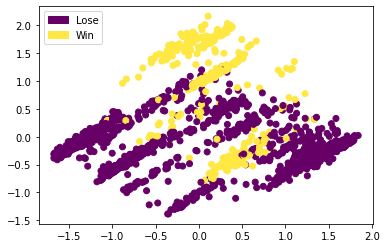

In [51]:
visualizations_with_pca.plot_df_pca(df_pca)

### Visual explanations: sole custody request

In [52]:
df_request_sole, df_request_joint = base_rates.df_by_group(df, "RQ_JOINT")

In [53]:
df_pca_request_sole = visualizations_with_pca.apply_pca(df_request_sole, cols_pca)
df_pca_request_sole

,pca_0,pca_1,label
6,1.227389,-0.976423,0
14,0.040880,-0.692081,0
15,-0.847871,-0.329951,0
18,-0.815828,-0.266375,0
20,-0.847980,-0.319428,0
...,...,...,...
1876,0.761094,-1.257554,0
1879,1.673371,1.196217,1
1880,-0.458296,0.013623,0
1882,-0.848291,0.916653,0


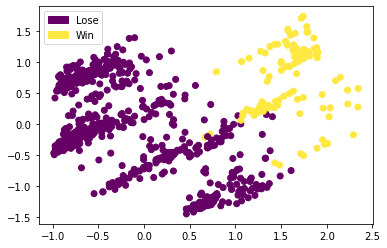

In [54]:
visualizations_with_pca.plot_df_pca(df_pca_request_sole)

### Visual explanations: joint custody request

In [55]:
df_pca_request_joint = visualizations_with_pca.apply_pca(df_request_joint, cols_pca)
df_pca_request_joint

,pca_0,pca_1,label
0,-0.514346,0.503490,0
1,-0.064809,-0.695041,0
2,-0.386844,0.744308,0
3,-0.501182,0.686223,0
4,-0.537210,-0.792505,0
...,...,...,...
1871,-0.678229,0.673274,0
1875,-0.686701,0.621220,0
1877,1.325694,-0.561206,1
1878,-0.157790,0.512862,0


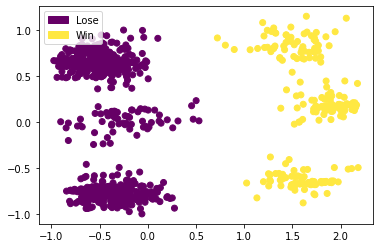

In [56]:
visualizations_with_pca.plot_df_pca(df_pca_request_joint)

<div class="alert alert-block alert-warning col-md-12">

<p>
By separating by request type, we can more easily see two differentiated clusters of data, which indicates that data can be more easily analysed in terms of winning and losing cases by dividing by the type of request. </p>

</div>

## Get sentence distances 

In [57]:
cols_similarity = distances.similarity_cols(features_classification_lists, show_removed_cols = True, show_cols_similarity = True)

The removed columns are:
['CD_JOINT', 'CD_JO_CF', 'WIN_SL', 'WINWIN', 'CD_FH_AT', 'CD_FH_SP', 'CD_MP_AT', 'CD_MP_SP', 'ID', 'URL', 'DATE', 'YEAR']

The columns used for similarity are:
['DEFEN_ML', 'FT_RP_b', 'FT_RP', 'FT_CW_b', 'FT_CW', 'FT_CC_b', 'FT_CC', 'FT_CR_b', 'FT_CR', 'FT_RA_b', 'FT_RA', 'FT_RD_b', 'FT_RD', 'FT_PD_b', 'FT_PD', 'FT_AG_b', 'FT_AG', 'FT_RP_SL_b', 'FT_RP_SL', 'FT_RP_JN_b', 'FT_RP_JN', 'FT_CW_SL_b', 'FT_CW_SL', 'FT_CW_JN_b', 'FT_CW_JN', 'FT_CC_SL_b', 'FT_CC_SL', 'FT_CC_JN_b', 'FT_CC_JN', 'FT_CR_SL_b', 'FT_CR_SL', 'FT_CR_JN_b', 'FT_CR_JN', 'FT_RA_SL_b', 'FT_RA_SL', 'FT_RA_JN_b', 'FT_RA_JN', 'FT_RD_SL_b', 'FT_RD_SL', 'FT_RD_JN_b', 'FT_RD_JN', 'FT_PD_SL_b', 'FT_PD_SL', 'FT_PD_JN_b', 'FT_PD_JN', 'FT_AG_SL_b', 'FT_AG_SL', 'FT_AG_JN_b', 'FT_AG_JN', 'FT_SL_IN_b', 'FT_JN_IN_b', 'FT_SL_IN', 'FT_JN_IN', 'JUDGE_ML', 'LN_JNPREF_b', 'LN_JNPREF', 'LP_BI_b', 'LP_BI', 'LP_PE_b', 'LP_PE', 'LP_RA_b', 'LP_RA', 'LP_RJ_b', 'LP_RJ', 'LP_BI_SL_b', 'LP_BI_SL', 'LP_BI_JN_b', 'LP_BI_JN', 'L

In [58]:
#distance_matrix = distances.create_distance_matrix(df, cols_similarity)
#distance_matrix

In [59]:
#distance_matrix.to_excel("..\output\distance_matrix.xlsx") 

In [60]:
#distance_matrix.to_csv("..\output\distance_matrix.csv", sep=";", index=False)

In [61]:
distance_matrix = pd.read_csv("..\output\distance_matrix.csv", sep=";")
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,0.000000,1.877135,1.950515,1.709627,1.118936,2.076318,2.197240,2.354973,2.001376,1.435019,...,3.187675,1.603008,2.573430,2.429890,1.760673,2.794258,2.364952,1.773004,3.215454,2.383094
1,1.877135,0.000000,1.952233,1.712824,1.334193,1.344815,1.676620,1.589493,2.350432,1.435731,...,2.944444,1.902515,1.900155,1.361793,2.023717,2.798271,2.574037,2.036307,2.795473,1.909980
2,1.950515,1.952233,0.000000,2.092846,2.013112,2.018973,2.163262,2.514171,1.950744,1.687473,...,3.232245,1.836439,2.721879,2.383767,2.427984,3.097164,2.982988,2.440853,3.335105,2.731160
3,1.709627,1.712824,2.092846,0.000000,1.781297,1.491161,1.752808,2.222199,1.707079,1.727993,...,3.014654,0.975718,2.128818,1.824701,1.738664,2.781926,2.920310,1.603344,3.045855,2.267022
4,1.118936,1.334193,2.013112,1.781297,0.000000,1.599792,2.253483,1.946885,2.062430,1.676730,...,2.899557,1.676171,2.318786,2.040824,2.087638,2.560848,2.201111,2.100404,3.098619,2.222933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,2.794258,2.798271,3.097164,2.781926,2.560848,2.457998,3.023976,2.519519,2.610110,2.892183,...,1.194271,2.719112,2.828130,2.775149,2.807126,0.000000,2.213511,2.994186,1.774262,2.544108
1880,2.364952,2.574037,2.982988,2.920310,2.201111,2.721918,2.815615,2.270414,3.099292,2.459908,...,2.470948,2.859764,2.883960,2.915640,2.862868,2.213511,0.000000,2.852769,2.631675,2.501222
1881,1.773004,2.036307,2.440853,1.603344,2.100404,1.850940,2.104595,2.386693,2.272592,1.760849,...,3.098750,1.648827,2.425733,1.835593,1.037938,2.994186,2.852769,0.000000,2.802795,2.068481
1882,3.215454,2.795473,3.335105,3.045855,3.098619,2.762074,2.754209,2.621869,3.218906,2.891459,...,1.986604,3.075336,2.539788,2.561318,2.796666,1.774262,2.631675,2.802795,0.000000,2.210772


In [62]:
#distances_df = distances.get_all_distances(distance_matrix)
#distances_df.tail()

In [63]:
#distances_df.to_csv("..\output\distances.csv", sep=";", index=False)

In [64]:
distances_df = pd.read_csv("..\output\distances.csv", sep=";")
distances_df.tail()

,sentence_1,sentence_2,distance
1773781,1880,1882,2.631675
1773782,1880,1883,2.501222
1773783,1881,1882,2.802795
1773784,1881,1883,2.068481
1773785,1882,1883,2.210772


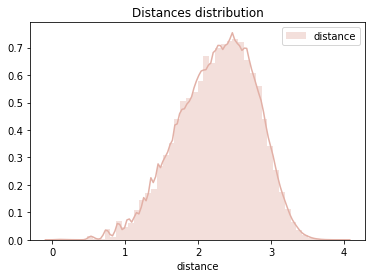

In [65]:
distances.distances_plot(distances_df)

## Data Separability

<div class="alert alert-block alert-info col-md-12">

<p>
Are the winning and losing cases well differentiated between them?
</p>

</div>

### Individual judge 

In [66]:
judge_31_sentences = data_separability.get_judge_sentences(df, 31)
judge_31_sentences.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
146,APB_2019_10543,http://labje.unizar.es/sentencias/APB_2019_105...,43662,2019,Barcelona,Cataluña,31,1,0,1,...,0,0.0,1,0,0,0,0,0,1,0
168,APB_2019_11509,http://labje.unizar.es/sentencias/APB_2019_115...,43734,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
178,APB_2019_11868,http://labje.unizar.es/sentencias/APB_2019_118...,43677,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,1,1,0,1,0,0,1,1
188,APB_2019_12073,http://labje.unizar.es/sentencias/APB_2019_120...,43754,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
194,APB_2019_12670,http://labje.unizar.es/sentencias/APB_2019_126...,43768,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,1,1,0,1,0,0,1,1


In [67]:
judge_31_distances_df = data_separability.get_judge_distances(df, distances_df, 31)
judge_31_distances_df

,sentence_1,sentence_2,distance
0,146,168,3.075203
1,146,178,2.420329
2,146,188,2.814421
3,146,194,2.443330
4,146,202,1.597730
...,...,...,...
698,347,355,2.472832
699,347,364,2.421587
700,348,355,2.460453
701,348,364,2.523216


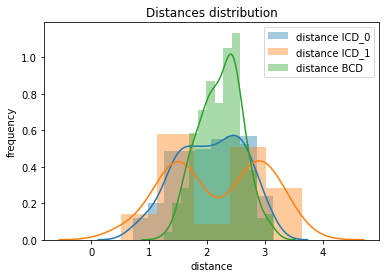

Mean for ICD_0 distribution: 2.057
Mean for ICD_1 distribution: 2.166
Mean for BCD distribution: 2.236

Mean for both ICD distribution: 2.111

Difference between BCD mean and ICD mean: 0.124


In [68]:
data_separability.plot_distances_distribution(df, judge_31_distances_df)

#### Individual judge: sole custody request

In [69]:
judge_31_sentences_request_sole = data_separability.get_judge_sentences(df_request_sole, 31)
judge_31_sentences_request_sole.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
146,APB_2019_10543,http://labje.unizar.es/sentencias/APB_2019_105...,43662,2019,Barcelona,Cataluña,31,1,0,1,...,0,0.0,1,0,0,0,0,0,1,0
202,APB_2019_13045,http://labje.unizar.es/sentencias/APB_2019_130...,43776,2019,Barcelona,Cataluña,31,1,0,1,...,0,0.0,0,1,0,0,0,0,0,0
230,APB_2019_14746,http://labje.unizar.es/sentencias/APB_2019_147...,43816,2019,Barcelona,Cataluña,31,1,0,1,...,0,0.0,1,0,0,0,0,0,1,1
244,APB_2019_15670,http://labje.unizar.es/sentencias/APB_2019_156...,43809,2019,Barcelona,Cataluña,31,1,0,1,...,0,0.0,0,1,1,1,0,0,1,0
256,APB_2019_404,http://labje.unizar.es/sentencias/APB_2019_404...,43494,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,1,0,0,0,0,0,0,0


In [70]:
judge_31_distances_df_request_sole = data_separability.get_judge_distances(df_request_sole, distances_df, 31)
judge_31_distances_df_request_sole

,sentence_1,sentence_2,distance
0,146,202,1.597730
1,146,230,1.543176
2,146,244,1.693414
3,146,256,1.875894
4,146,267,2.285447
...,...,...,...
86,343,355,1.832610
87,343,364,1.759970
88,345,355,1.973534
89,345,364,1.604788


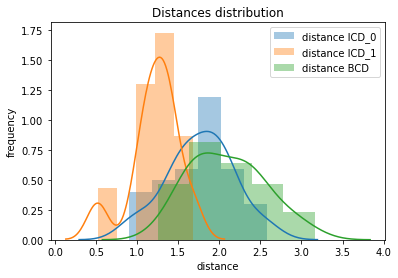

Mean for ICD_0 distribution: 1.765
Mean for ICD_1 distribution: 1.216
Mean for BCD distribution: 2.095

Mean for both ICD distribution: 1.49

Difference between BCD mean and ICD mean: 0.604


In [71]:
data_separability.plot_distances_distribution(df_request_sole, judge_31_distances_df_request_sole)

#### Individual judge: joint custody request

In [72]:
judge_31_sentences_request_joint = data_separability.get_judge_sentences(df_request_joint, 31)
judge_31_sentences_request_joint.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
168,APB_2019_11509,http://labje.unizar.es/sentencias/APB_2019_115...,43734,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
178,APB_2019_11868,http://labje.unizar.es/sentencias/APB_2019_118...,43677,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,1,1,0,1,0,0,1,1
188,APB_2019_12073,http://labje.unizar.es/sentencias/APB_2019_120...,43754,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
194,APB_2019_12670,http://labje.unizar.es/sentencias/APB_2019_126...,43768,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,1,1,0,1,0,0,1,1
204,APB_2019_13055,http://labje.unizar.es/sentencias/APB_2019_130...,43773,2019,Barcelona,Cataluña,31,1,1,0,...,0,0.0,1,1,0,1,1,1,1,0


In [73]:
judge_31_distances_df_request_joint = data_separability.get_judge_distances(df_request_joint, distances_df, 31)
judge_31_distances_df_request_joint

,sentence_1,sentence_2,distance
0,168,178,2.619810
1,168,188,1.260311
2,168,194,2.408762
3,168,204,2.761549
4,168,214,1.754148
...,...,...,...
271,331,347,1.710261
272,331,348,1.980677
273,346,347,2.213072
274,346,348,2.429032


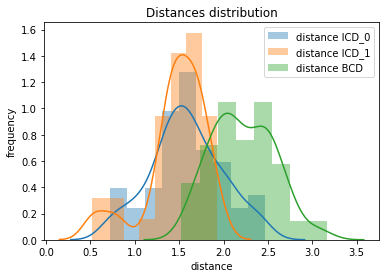

Mean for ICD_0 distribution: 1.58
Mean for ICD_1 distribution: 1.467
Mean for BCD distribution: 2.218

Mean for both ICD distribution: 1.523

Difference between BCD mean and ICD mean: 0.695


In [74]:
data_separability.plot_distances_distribution(df, judge_31_distances_df_request_joint)

### Female judges

In [75]:
sentences_female_judges = data_separability.get_sentences_by_gender(df, 0)
sentences_female_judges.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
3,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,43600,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
5,APA_2019_2288,http://labje.unizar.es/sentencias/APA_2019_228...,43628,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,0,0
8,APA_2019_2390,http://labje.unizar.es/sentencias/APA_2019_239...,43635,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,1,1,0,1
10,APA_2019_2442,http://labje.unizar.es/sentencias/APA_2019_244...,43649,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
11,APA_2019_2518,http://labje.unizar.es/sentencias/APA_2019_251...,43481,2019,Alicante,Comunidad Valenciana,4,0,1,0,...,0,0.0,1,1,0,1,0,0,0,1


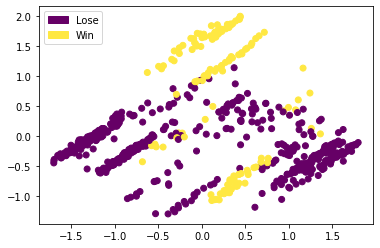

In [76]:
df_females_pca = visualizations_with_pca.apply_pca(sentences_female_judges, cols_pca)
visualizations_with_pca.plot_df_pca(df_females_pca)

In [77]:
#female_distances_df = data_separability.get_distances_by_gender(df, distances_df, 0)
#female_distances_df

In [78]:
#female_distances_df.to_csv("..\output\distances_female_judges.csv", sep=";", index=False)

In [79]:
female_distances_df = pd.read_csv("..\output\distances_female_judges.csv", sep=";")
female_distances_df

,sentence_1,sentence_2,distance,label_comparison
0,3,5,1.491161,ICD_0
1,3,8,1.707079,ICD_0
2,3,10,0.712760,ICD_0
3,3,11,1.567040,BCD
4,3,15,2.647204,ICD_0
...,...,...,...,...
237700,1879,1882,1.774262,BCD
237701,1879,1883,2.544108,BCD
237702,1881,1882,2.802795,BCD
237703,1881,1883,2.068481,BCD


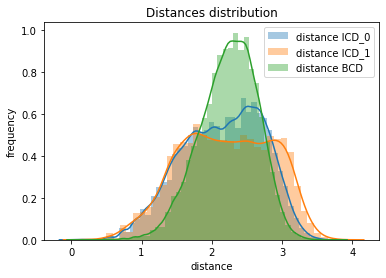

Mean for ICD_0 distribution: 2.15
Mean for ICD_1 distribution: 2.199
Mean for BCD distribution: 2.238

Mean for both ICD distribution: 2.174

Difference between BCD mean and ICD mean: 0.064


In [80]:
data_separability.plot_distances_distribution(df, female_distances_df)

#### Female judges: sole custody request

In [81]:
sentences_female_judges_request_sole = data_separability.get_sentences_by_gender(df_request_sole, 0)
sentences_female_judges_request_sole.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
15,APA_2019_2996,http://labje.unizar.es/sentencias/APA_2019_299...,43796,2019,Alicante,Comunidad Valenciana,4,0,0,1,...,0,0.0,1,0,0,0,0,0,0,0
35,APA_2019_3508,http://labje.unizar.es/sentencias/APA_2019_350...,43733,2019,Alicante,Comunidad Valenciana,2,0,0,1,...,0,0.0,1,0,0,0,0,0,0,0
42,APA_2019_4051,http://labje.unizar.es/sentencias/APA_2019_405...,43754,2019,Alicante,Comunidad Valenciana,4,0,1,0,...,0,0.0,0,1,0,0,0,1,1,1
75,APAL_2016_1382,http://labje.unizar.es/sentencias/APAL_2016_13...,42695,2016,Almería,Andalucía,15,0,0,1,...,0,0.0,0,1,0,0,0,1,1,0
79,APAL_2017_1373,http://labje.unizar.es/sentencias/APAL_2017_13...,42997,2017,Almería,Andalucía,15,0,0,1,...,0,0.0,1,0,0,0,0,0,0,0


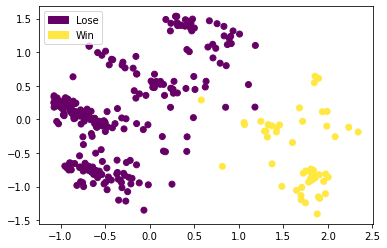

In [82]:
df_females_pca_request_sole = visualizations_with_pca.apply_pca(sentences_female_judges_request_sole, cols_pca)
visualizations_with_pca.plot_df_pca(df_females_pca_request_sole)

In [83]:
female_distances_df_request_sole = data_separability.get_distances_by_gender(df_request_sole, distances_df, 0)
female_distances_df_request_sole

,sentence_1,sentence_2,distance
0,15,35,1.901227
1,15,42,2.465599
2,15,75,1.606306
3,15,79,1.782838
4,15,126,2.370559
...,...,...,...
48200,1876,1882,2.539788
48201,1876,1883,1.292718
48202,1879,1882,1.774262
48203,1879,1883,2.544108


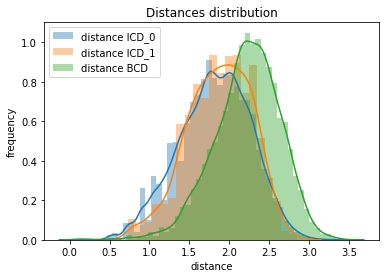

Mean for ICD_0 distribution: 1.817
Mean for ICD_1 distribution: 1.872
Mean for BCD distribution: 2.223

Mean for both ICD distribution: 1.845

Difference between BCD mean and ICD mean: 0.378


In [84]:
data_separability.plot_distances_distribution(df_request_sole, female_distances_df_request_sole)

##### Female judges: sole custody request, female plaintiff

In [85]:
df_request_sole_plaintiff_female, df_request_sole_plaintiff_male = base_rates.df_by_group(df_request_sole, "PLAIN_ML")

In [86]:
sentences_female_judges_request_sole_plaintiff_female = data_separability.get_sentences_by_gender(df_request_sole_plaintiff_female, 0)
sentences_female_judges_request_sole_plaintiff_female.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
15,APA_2019_2996,http://labje.unizar.es/sentencias/APA_2019_299...,43796,2019,Alicante,Comunidad Valenciana,4,0,0,1,...,0,0.0,1,0,0,0,0,0,0,0
35,APA_2019_3508,http://labje.unizar.es/sentencias/APA_2019_350...,43733,2019,Alicante,Comunidad Valenciana,2,0,0,1,...,0,0.0,1,0,0,0,0,0,0,0
75,APAL_2016_1382,http://labje.unizar.es/sentencias/APAL_2016_13...,42695,2016,Almería,Andalucía,15,0,0,1,...,0,0.0,0,1,0,0,0,1,1,0
79,APAL_2017_1373,http://labje.unizar.es/sentencias/APAL_2017_13...,42997,2017,Almería,Andalucía,15,0,0,1,...,0,0.0,1,0,0,0,0,0,0,0
126,APB_2015_6302,http://labje.unizar.es/sentencias/APB_2015_630...,42150,2015,Barcelona,Cataluña,21,0,0,1,...,0,0.0,0,1,0,0,0,1,0,1


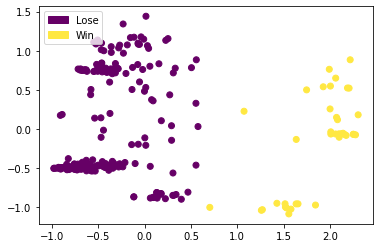

In [87]:
df_females_pca_request_sole_plaintiff_female = visualizations_with_pca.apply_pca(sentences_female_judges_request_sole_plaintiff_female, cols_pca)
visualizations_with_pca.plot_df_pca(df_females_pca_request_sole_plaintiff_female)

In [88]:
female_distances_df_request_sole_plaintiff_female = data_separability.get_distances_by_gender(df_request_sole_plaintiff_female, distances_df, 0)
female_distances_df_request_sole_plaintiff_female

,sentence_1,sentence_2,distance
0,15,35,1.901227
1,15,75,1.606306
2,15,79,1.782838
3,15,126,2.370559
4,15,127,2.448949
...,...,...,...
27725,1873,1879,2.171452
27726,1873,1882,2.049731
27727,1874,1879,1.194271
27728,1874,1882,1.986604


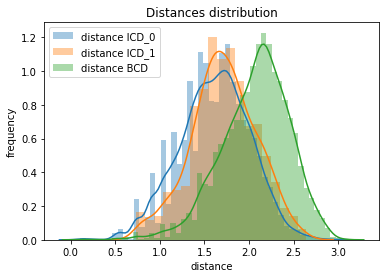

Mean for ICD_0 distribution: 1.612
Mean for ICD_1 distribution: 1.711
Mean for BCD distribution: 2.07

Mean for both ICD distribution: 1.661

Difference between BCD mean and ICD mean: 0.408


In [89]:
data_separability.plot_distances_distribution(df_request_sole_plaintiff_female, female_distances_df_request_sole_plaintiff_female)

##### Female judges: sole custody request, male plaintiff

In [90]:
sentences_female_judges_request_sole_plaintiff_male = data_separability.get_sentences_by_gender(df_request_sole_plaintiff_male, 0)
sentences_female_judges_request_sole_plaintiff_male.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
42,APA_2019_4051,http://labje.unizar.es/sentencias/APA_2019_405...,43754,2019,Alicante,Comunidad Valenciana,4,0,1,0,...,0,0.0,0,1,0,0,0,1,1,1
132,APB_2018_12268,http://labje.unizar.es/sentencias/APB_2018_122...,43445,2018,Barcelona,Cataluña,22,0,1,0,...,0,0.0,0,1,0,0,0,0,0,0
133,APB_2018_13581,http://labje.unizar.es/sentencias/APB_2018_135...,43455,2018,Barcelona,Cataluña,25,0,1,0,...,0,0.0,0,1,0,0,0,1,1,0
160,APB_2019_11318,http://labje.unizar.es/sentencias/APB_2019_113...,43733,2019,Barcelona,Cataluña,27,0,1,0,...,0,0.0,0,1,1,1,0,0,0,1
163,APB_2019_11490,http://labje.unizar.es/sentencias/APB_2019_114...,43739,2019,Barcelona,Cataluña,30,0,1,0,...,0,0.0,0,1,0,0,0,0,1,0


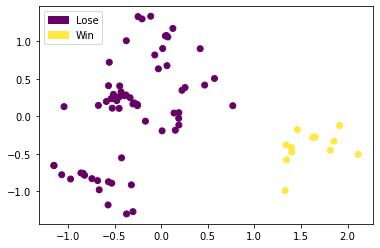

In [91]:
df_females_pca_request_sole_plaintiff_male = visualizations_with_pca.apply_pca(sentences_female_judges_request_sole_plaintiff_male, cols_pca)
visualizations_with_pca.plot_df_pca(df_females_pca_request_sole_plaintiff_male)

In [92]:
female_distances_df_request_sole_plaintiff_male = data_separability.get_distances_by_gender(df_request_sole_plaintiff_male, distances_df, 0)
female_distances_df_request_sole_plaintiff_male

,sentence_1,sentence_2,distance
0,42,132,2.114804
1,42,133,1.484830
2,42,160,2.331165
3,42,163,2.240661
4,42,206,1.543560
...,...,...,...
2770,1845,1876,2.066480
2771,1845,1883,1.794428
2772,1860,1876,2.190970
2773,1860,1883,2.071945


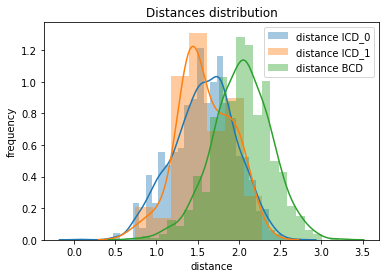

Mean for ICD_0 distribution: 1.58
Mean for ICD_1 distribution: 1.585
Mean for BCD distribution: 2.028

Mean for both ICD distribution: 1.582

Difference between BCD mean and ICD mean: 0.445


In [93]:
data_separability.plot_distances_distribution(df_request_sole_plaintiff_male, female_distances_df_request_sole_plaintiff_male)

#### Female judges: joint custody request

In [94]:
sentences_female_judges_request_joint = data_separability.get_sentences_by_gender(df_request_joint, 0)
sentences_female_judges_request_joint.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
3,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,43600,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
5,APA_2019_2288,http://labje.unizar.es/sentencias/APA_2019_228...,43628,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,0,0
8,APA_2019_2390,http://labje.unizar.es/sentencias/APA_2019_239...,43635,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,1,1,0,1
10,APA_2019_2442,http://labje.unizar.es/sentencias/APA_2019_244...,43649,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
11,APA_2019_2518,http://labje.unizar.es/sentencias/APA_2019_251...,43481,2019,Alicante,Comunidad Valenciana,4,0,1,0,...,0,0.0,1,1,0,1,0,0,0,1


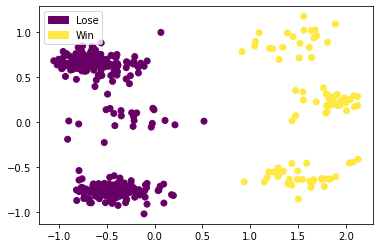

In [95]:
df_females_pca_request_joint = visualizations_with_pca.apply_pca(sentences_female_judges_request_joint, cols_pca)
visualizations_with_pca.plot_df_pca(df_females_pca_request_joint)

In [96]:
female_distances_df_request_joint = data_separability.get_distances_by_gender(df_request_joint, distances_df, 0)
female_distances_df_request_joint

,sentence_1,sentence_2,distance
0,3,5,1.491161
1,3,8,1.707079
2,3,10,0.712760
3,3,11,1.567040
4,3,16,1.653735
...,...,...,...
71626,1875,1878,1.778858
71627,1875,1881,1.648827
71628,1877,1878,1.668004
71629,1877,1881,1.835593


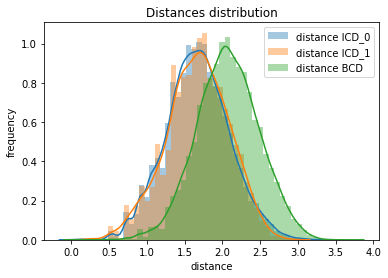

Mean for ICD_0 distribution: 1.673
Mean for ICD_1 distribution: 1.67
Mean for BCD distribution: 2.071

Mean for both ICD distribution: 1.671

Difference between BCD mean and ICD mean: 0.4


In [97]:
data_separability.plot_distances_distribution(df_request_joint, female_distances_df_request_joint)

##### Female judges: joint custody request, female plaintiff

In [98]:
df_request_joint_plaintiff_female, df_request_joint_plaintiff_male = base_rates.df_by_group(df_request_joint, "PLAIN_ML")

In [99]:
sentences_female_judges_request_joint_plaintiff_female = data_separability.get_sentences_by_gender(df_request_joint_plaintiff_female, 0)
sentences_female_judges_request_joint_plaintiff_female.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
33,APA_2019_3504,http://labje.unizar.es/sentencias/APA_2019_350...,43748,2019,Alicante,Comunidad Valenciana,2,0,0,1,...,0,0.0,0,0,0,0,0,0,0,0
128,APB_2016_13520,http://labje.unizar.es/sentencias/APB_2016_135...,42726,2016,Barcelona,Cataluña,23,0,0,1,...,0,0.0,0,0,0,0,0,1,1,1
151,APB_2019_10962,http://labje.unizar.es/sentencias/APB_2019_109...,43724,2019,Barcelona,Cataluña,25,0,0,1,...,0,0.0,1,1,0,1,0,0,0,0
196,APB_2019_12835,http://labje.unizar.es/sentencias/APB_2019_128...,43762,2019,Barcelona,Cataluña,21,0,0,1,...,0,0.0,0,0,0,0,0,0,0,0
231,APB_2019_14768,http://labje.unizar.es/sentencias/APB_2019_147...,43798,2019,Barcelona,Cataluña,30,0,0,1,...,0,0.0,1,1,0,1,0,1,0,1


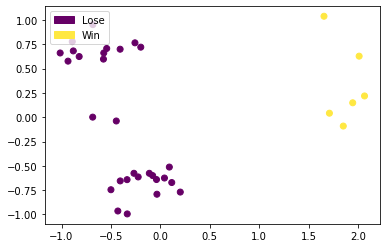

In [100]:
df_females_pca_request_joint_plaintiff_female = visualizations_with_pca.apply_pca(sentences_female_judges_request_joint_plaintiff_female, cols_pca)
visualizations_with_pca.plot_df_pca(df_females_pca_request_joint_plaintiff_female)

In [101]:
female_distances_df_request_joint_plaintiff_female = data_separability.get_distances_by_gender(df_request_joint_plaintiff_female, distances_df, 0)
female_distances_df_request_joint_plaintiff_female

,sentence_1,sentence_2,distance
0,33,128,1.884522
1,33,151,1.595718
2,33,196,1.432369
3,33,231,2.581964
4,33,259,0.528369
...,...,...,...
590,1630,1747,1.442619
591,1630,1809,1.852474
592,1636,1747,1.779189
593,1636,1809,2.023747


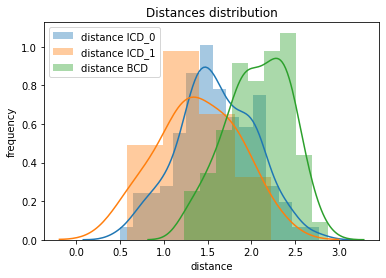

Mean for ICD_0 distribution: 1.598
Mean for ICD_1 distribution: 1.395
Mean for BCD distribution: 2.072

Mean for both ICD distribution: 1.497

Difference between BCD mean and ICD mean: 0.576


In [102]:
data_separability.plot_distances_distribution(df_request_joint_plaintiff_female, female_distances_df_request_joint_plaintiff_female)

##### Female judges: joint custody request, male plaintiff

In [103]:
sentences_female_judges_request_joint_plaintiff_male = data_separability.get_sentences_by_gender(df_request_joint_plaintiff_male, 0)
sentences_female_judges_request_joint_plaintiff_male.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
3,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,43600,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
5,APA_2019_2288,http://labje.unizar.es/sentencias/APA_2019_228...,43628,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,0,0
8,APA_2019_2390,http://labje.unizar.es/sentencias/APA_2019_239...,43635,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,1,1,0,1
10,APA_2019_2442,http://labje.unizar.es/sentencias/APA_2019_244...,43649,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
11,APA_2019_2518,http://labje.unizar.es/sentencias/APA_2019_251...,43481,2019,Alicante,Comunidad Valenciana,4,0,1,0,...,0,0.0,1,1,0,1,0,0,0,1


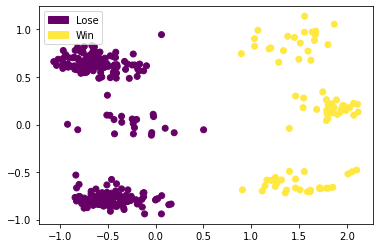

In [104]:
df_females_pca_request_joint_plaintiff_male = visualizations_with_pca.apply_pca(sentences_female_judges_request_joint_plaintiff_male, cols_pca)
visualizations_with_pca.plot_df_pca(df_females_pca_request_joint_plaintiff_male)

In [105]:
female_distances_df_request_joint_plaintiff_male = data_separability.get_distances_by_gender(df_request_joint_plaintiff_male, distances_df, 0)
female_distances_df_request_joint_plaintiff_male

,sentence_1,sentence_2,distance
0,3,5,1.491161
1,3,8,1.707079
2,3,10,0.712760
3,3,11,1.567040
4,3,16,1.653735
...,...,...,...
58991,1875,1878,1.778858
58992,1875,1881,1.648827
58993,1877,1878,1.668004
58994,1877,1881,1.835593


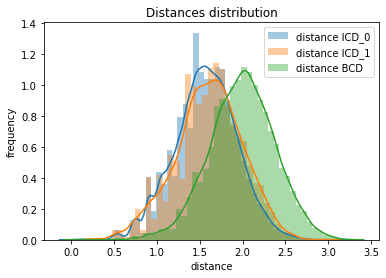

Mean for ICD_0 distribution: 1.569
Mean for ICD_1 distribution: 1.605
Mean for BCD distribution: 1.994

Mean for both ICD distribution: 1.587

Difference between BCD mean and ICD mean: 0.407


In [106]:
data_separability.plot_distances_distribution(df_request_joint_plaintiff_male, female_distances_df_request_joint_plaintiff_male)

### Male judges

In [107]:
sentences_male_judges = data_separability.get_sentences_by_gender(df, 1)
sentences_male_judges.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
0,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,43362,2018,Alicante,Comunidad Valenciana,0,1,1,0,...,0,0.0,0,0,0,0,0,0,1,0
1,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,43621,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
2,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,43607,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,1,0,1,0
4,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,43818,2019,Barcelona,Cataluña,3,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
6,APA_2019_2289,http://labje.unizar.es/sentencias/APA_2019_228...,43628,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,1,0,0,0,0,1,0


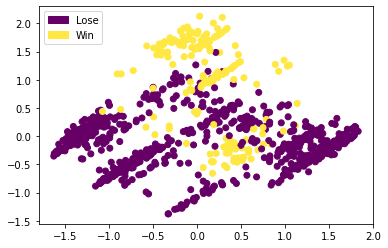

In [108]:
df_males_pca = visualizations_with_pca.apply_pca(sentences_male_judges, cols_pca)
visualizations_with_pca.plot_df_pca(df_males_pca)

In [109]:
#male_distances_df = data_separability.get_distances_by_gender(df, distances_df, 1)
#male_distances_df

In [110]:
#male_distances_df.to_csv("..\output\distances_male_judges.csv", sep=";", index=False)

In [111]:
male_distances_df = pd.read_csv("..\output\distances_male_judges.csv", sep=";")
male_distances_df

,sentence_1,sentence_2,distance,label_comparison
0,0,1,1.877135,ICD_0
1,0,2,1.950515,ICD_0
2,0,4,1.118936,ICD_0
3,0,6,2.197240,ICD_0
4,0,7,2.354973,ICD_0
...,...,...,...,...
712216,1868,1872,2.613433,ICD_0
712217,1868,1880,2.426063,ICD_0
712218,1869,1872,2.129417,BCD
712219,1869,1880,2.576752,BCD


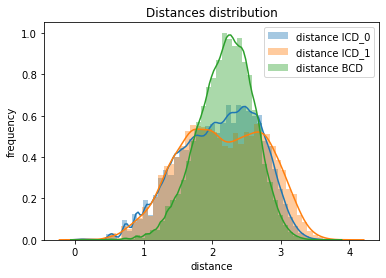

Mean for ICD_0 distribution: 2.1
Mean for ICD_1 distribution: 2.147
Mean for BCD distribution: 2.196

Mean for both ICD distribution: 2.124

Difference between BCD mean and ICD mean: 0.073


In [112]:
data_separability.plot_distances_distribution(df, male_distances_df)

#### Male judges: sole custody request

In [113]:
sentences_male_judges_request_sole = data_separability.get_sentences_by_gender(df_request_sole, 1)
sentences_male_judges_request_sole.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
6,APA_2019_2289,http://labje.unizar.es/sentencias/APA_2019_228...,43628,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,1,0,0,0,0,1,0
14,APA_2019_2712,http://labje.unizar.es/sentencias/APA_2019_271...,43754,2019,Alicante,Comunidad Valenciana,0,1,0,1,...,0,0.0,0,1,0,0,0,0,0,0
18,APA_2019_3073,http://labje.unizar.es/sentencias/APA_2019_307...,43803,2019,Alicante,Comunidad Valenciana,1,1,0,1,...,0,0.0,1,0,0,0,0,0,0,0
20,APA_2019_3206,http://labje.unizar.es/sentencias/APA_2019_320...,43642,2019,Elche,Comunidad Valenciana,5,1,0,1,...,0,0.0,1,0,0,0,0,0,0,0
21,APA_2019_3207,http://labje.unizar.es/sentencias/APA_2019_320...,43643,2019,Elche,Comunidad Valenciana,6,1,1,0,...,0,0.0,1,0,0,0,0,0,0,1


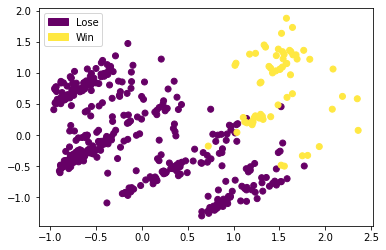

In [114]:
df_males_pca_request_sole = visualizations_with_pca.apply_pca(sentences_male_judges_request_sole, cols_pca)
visualizations_with_pca.plot_df_pca(df_males_pca_request_sole)

In [115]:
male_distances_df_request_sole = data_separability.get_distances_by_gender(df_request_sole, distances_df, 1)
male_distances_df_request_sole

,sentence_1,sentence_2,distance
0,6,14,2.311177
1,6,18,2.253660
2,6,20,2.344675
3,6,21,2.093824
4,6,22,2.265477
...,...,...,...
146606,1854,1872,2.335594
146607,1854,1880,2.125565
146608,1857,1872,1.743867
146609,1857,1880,2.671805


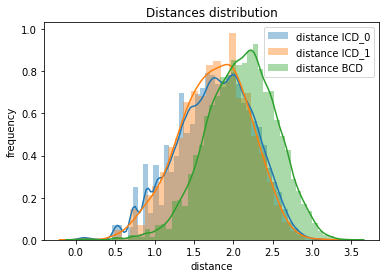

Mean for ICD_0 distribution: 1.767
Mean for ICD_1 distribution: 1.759
Mean for BCD distribution: 2.103

Mean for both ICD distribution: 1.763

Difference between BCD mean and ICD mean: 0.34


In [116]:
data_separability.plot_distances_distribution(df_request_sole, male_distances_df_request_sole)

##### Male judges: sole custody request, female plaintiff

In [117]:
sentences_male_judges_request_sole_plaintiff_female = data_separability.get_sentences_by_gender(df_request_sole_plaintiff_female, 1)
sentences_male_judges_request_sole_plaintiff_female.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
14,APA_2019_2712,http://labje.unizar.es/sentencias/APA_2019_271...,43754,2019,Alicante,Comunidad Valenciana,0,1,0,1,...,0,0.0,0,1,0,0,0,0,0,0
18,APA_2019_3073,http://labje.unizar.es/sentencias/APA_2019_307...,43803,2019,Alicante,Comunidad Valenciana,1,1,0,1,...,0,0.0,1,0,0,0,0,0,0,0
20,APA_2019_3206,http://labje.unizar.es/sentencias/APA_2019_320...,43642,2019,Elche,Comunidad Valenciana,5,1,0,1,...,0,0.0,1,0,0,0,0,0,0,0
22,APA_2019_3419,http://labje.unizar.es/sentencias/APA_2019_341...,43748,2019,Alicante,Comunidad Valenciana,0,1,0,1,...,0,0.0,1,0,0,0,0,0,0,0
25,APA_2019_3436,http://labje.unizar.es/sentencias/APA_2019_343...,43726,2019,Alicante,Comunidad Valenciana,1,1,0,1,...,0,0.0,1,0,0,0,0,0,1,0


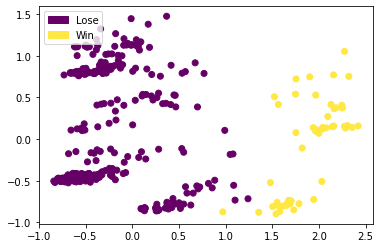

In [118]:
df_males_pca_request_sole_plaintiff_female = visualizations_with_pca.apply_pca(sentences_male_judges_request_sole_plaintiff_female, cols_pca)
visualizations_with_pca.plot_df_pca(df_males_pca_request_sole_plaintiff_female)

In [119]:
male_distances_df_request_sole_plaintiff_female = data_separability.get_distances_by_gender(df_request_sole_plaintiff_female, distances_df, 1)
male_distances_df_request_sole_plaintiff_female

,sentence_1,sentence_2,distance
0,14,18,0.890192
1,14,20,1.036244
2,14,22,1.527533
3,14,25,1.516300
4,14,26,0.883519
...,...,...,...
85900,1829,1854,1.661149
85901,1829,1880,2.086766
85902,1830,1854,1.717044
85903,1830,1880,1.905767


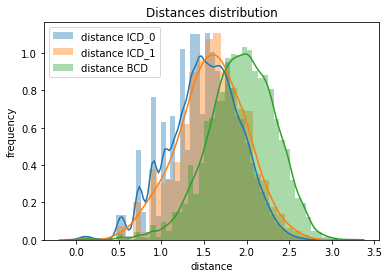

Mean for ICD_0 distribution: 1.51
Mean for ICD_1 distribution: 1.592
Mean for BCD distribution: 1.941

Mean for both ICD distribution: 1.551

Difference between BCD mean and ICD mean: 0.39


In [120]:
data_separability.plot_distances_distribution(df_request_sole_plaintiff_female, male_distances_df_request_sole_plaintiff_female)

##### Male judges: sole custody request, male plaintiff

In [121]:
sentences_male_judges_request_sole_plaintiff_male = data_separability.get_sentences_by_gender(df_request_sole_plaintiff_male, 1)
sentences_male_judges_request_sole_plaintiff_male.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
6,APA_2019_2289,http://labje.unizar.es/sentencias/APA_2019_228...,43628,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,1,0,0,0,0,1,0
21,APA_2019_3207,http://labje.unizar.es/sentencias/APA_2019_320...,43643,2019,Elche,Comunidad Valenciana,6,1,1,0,...,0,0.0,1,0,0,0,0,0,0,1
23,APA_2019_3422,http://labje.unizar.es/sentencias/APA_2019_342...,43803,2019,Alicante,Comunidad Valenciana,0,1,1,0,...,0,0.0,1,0,0,0,1,0,0,0
24,APA_2019_3426,http://labje.unizar.es/sentencias/APA_2019_342...,43789,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,1,0,0,0,0,0,1,0
30,APA_2019_3456,http://labje.unizar.es/sentencias/APA_2019_345...,43734,2019,Elche,Comunidad Valenciana,8,1,1,0,...,0,0.0,1,0,0,0,0,1,1,0


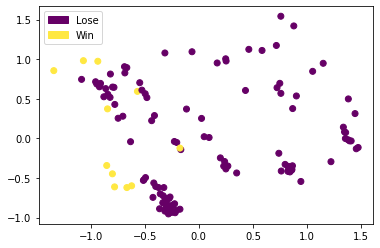

In [122]:
df_males_pca_request_sole_plaintiff_male = visualizations_with_pca.apply_pca(sentences_male_judges_request_sole_plaintiff_male, cols_pca)
visualizations_with_pca.plot_df_pca(df_males_pca_request_sole_plaintiff_male)

In [123]:
male_distances_df_request_sole_plaintiff_male = data_separability.get_distances_by_gender(df_request_sole_plaintiff_male, distances_df, 1)
male_distances_df_request_sole_plaintiff_male

,sentence_1,sentence_2,distance
0,6,21,2.093824
1,6,23,1.822457
2,6,24,1.138812
3,6,30,1.957468
4,6,45,2.022897
...,...,...,...
7996,1824,1857,1.618251
7997,1824,1872,2.036266
7998,1827,1857,1.942619
7999,1827,1872,1.120564


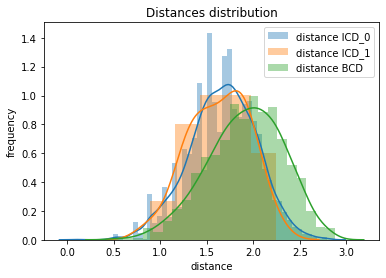

Mean for ICD_0 distribution: 1.67
Mean for ICD_1 distribution: 1.629
Mean for BCD distribution: 1.915

Mean for both ICD distribution: 1.649

Difference between BCD mean and ICD mean: 0.266


In [124]:
data_separability.plot_distances_distribution(df_request_sole_plaintiff_male, male_distances_df_request_sole_plaintiff_male)

#### Male judges: joint custody request

In [125]:
sentences_male_judges_request_joint = data_separability.get_sentences_by_gender(df_request_joint, 1)
sentences_male_judges_request_joint.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
0,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,43362,2018,Alicante,Comunidad Valenciana,0,1,1,0,...,0,0.0,0,0,0,0,0,0,1,0
1,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,43621,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
2,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,43607,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,1,0,1,0
4,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,43818,2019,Barcelona,Cataluña,3,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
7,APA_2019_2387,http://labje.unizar.es/sentencias/APA_2019_238...,43649,2019,Alicante,Comunidad Valenciana,0,1,0,1,...,0,0.0,0,0,0,0,0,0,0,0


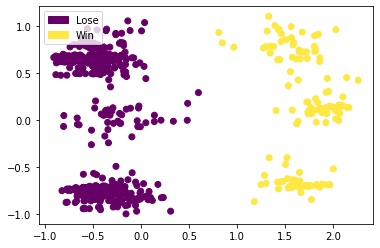

In [126]:
df_males_pca_request_joint = visualizations_with_pca.apply_pca(sentences_male_judges_request_joint, cols_pca)
visualizations_with_pca.plot_df_pca(df_males_pca_request_joint)

In [127]:
male_distances_df_request_joint = data_separability.get_distances_by_gender(df_request_joint, distances_df, 1)
male_distances_df_request_joint

,sentence_1,sentence_2,distance
0,0,1,1.877135
1,0,2,1.950515
2,0,4,1.118936
3,0,7,2.354973
4,0,9,1.435019
...,...,...,...
212221,1861,1868,1.530471
212222,1861,1869,1.598892
212223,1867,1868,1.762191
212224,1867,1869,1.693947


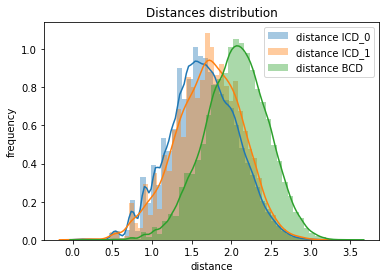

Mean for ICD_0 distribution: 1.643
Mean for ICD_1 distribution: 1.712
Mean for BCD distribution: 2.054

Mean for both ICD distribution: 1.677

Difference between BCD mean and ICD mean: 0.377


In [128]:
data_separability.plot_distances_distribution(df_request_joint, male_distances_df_request_joint)

##### Male judges: joint custody request, female plaintiff

In [129]:
sentences_male_judges_request_joint_plaintiff_female = data_separability.get_sentences_by_gender(df_request_joint_plaintiff_female, 1)
sentences_male_judges_request_joint_plaintiff_female.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
7,APA_2019_2387,http://labje.unizar.es/sentencias/APA_2019_238...,43649,2019,Alicante,Comunidad Valenciana,0,1,0,1,...,0,0.0,0,0,0,0,0,0,0,0
28,APA_2019_3451,http://labje.unizar.es/sentencias/APA_2019_345...,43753,2019,Elche,Comunidad Valenciana,7,1,0,1,...,0,0.0,0,0,0,0,0,0,0,0
71,APAL_2016_1312,http://labje.unizar.es/sentencias/APAL_2016_13...,42559,2016,Almería,Andalucía,13,1,0,1,...,0,0.0,0,0,0,0,0,0,0,0
116,APAV_2019_204,http://labje.unizar.es/sentencias/APAV_2019_20...,43557,2019,Ávila,Castilla y León,20,1,0,1,...,0,0.0,1,1,0,1,0,0,1,0
183,APB_2019_12027,http://labje.unizar.es/sentencias/APB_2019_120...,43748,2019,Barcelona,Cataluña,26,1,0,1,...,0,0.0,0,0,0,0,0,0,1,0


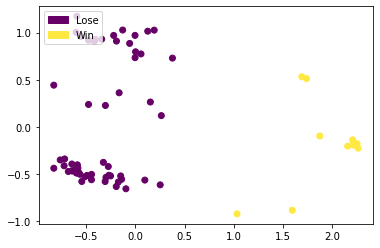

In [130]:
df_males_pca_request_joint_plaintiff_female = visualizations_with_pca.apply_pca(sentences_male_judges_request_joint_plaintiff_female, cols_pca)
visualizations_with_pca.plot_df_pca(df_males_pca_request_joint_plaintiff_female)

In [131]:
male_distances_df_request_joint_plaintiff_female = data_separability.get_distances_by_gender(df_request_joint_plaintiff_female, distances_df, 1)
male_distances_df_request_joint_plaintiff_female

,sentence_1,sentence_2,distance
0,7,28,1.461428
1,7,71,1.453077
2,7,116,1.811005
3,7,183,1.134228
4,7,209,2.147005
...,...,...,...
2206,1797,1811,1.743309
2207,1797,1836,2.023399
2208,1805,1811,1.597188
2209,1805,1836,1.759151


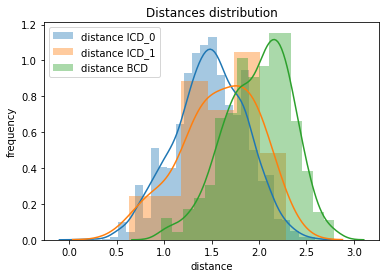

Mean for ICD_0 distribution: 1.481
Mean for ICD_1 distribution: 1.586
Mean for BCD distribution: 1.99

Mean for both ICD distribution: 1.533

Difference between BCD mean and ICD mean: 0.456


In [132]:
data_separability.plot_distances_distribution(df_request_joint_plaintiff_female, male_distances_df_request_joint_plaintiff_female)

##### Male judges: joint custody request, male plaintiff

In [133]:
sentences_male_judges_request_joint_plaintiff_male = data_separability.get_sentences_by_gender(df_request_joint_plaintiff_male, 1)
sentences_male_judges_request_joint_plaintiff_male.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
0,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,43362,2018,Alicante,Comunidad Valenciana,0,1,1,0,...,0,0.0,0,0,0,0,0,0,1,0
1,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,43621,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
2,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,43607,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,1,0,1,0
4,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,43818,2019,Barcelona,Cataluña,3,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
9,APA_2019_2441,http://labje.unizar.es/sentencias/APA_2019_244...,43649,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,1,1,0,1,0,0,1,0


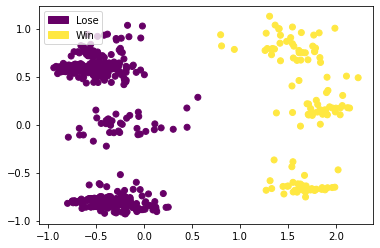

In [134]:
df_males_pca_request_joint_plaintiff_male = visualizations_with_pca.apply_pca(sentences_male_judges_request_joint_plaintiff_male, cols_pca)
visualizations_with_pca.plot_df_pca(df_males_pca_request_joint_plaintiff_male)

In [135]:
male_distances_df_request_joint_plaintiff_male = data_separability.get_distances_by_gender(df_request_joint_plaintiff_male, distances_df, 1)
male_distances_df_request_joint_plaintiff_male

,sentence_1,sentence_2,distance
0,0,1,1.877135
1,0,2,1.950515
2,0,4,1.118936
3,0,9,1.435019
4,0,12,1.005541
...,...,...,...
170815,1861,1868,1.530471
170816,1861,1869,1.598892
170817,1867,1868,1.762191
170818,1867,1869,1.693947


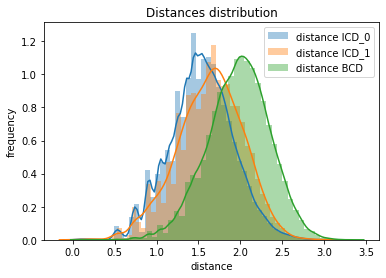

Mean for ICD_0 distribution: 1.535
Mean for ICD_1 distribution: 1.636
Mean for BCD distribution: 1.977

Mean for both ICD distribution: 1.586

Difference between BCD mean and ICD mean: 0.391


In [136]:
data_separability.plot_distances_distribution(df_request_joint_plaintiff_male, male_distances_df_request_joint_plaintiff_male)

<div class="alert alert-block alert-success col-md-12">

<p>
First, we can observe that data separability is only found when dividing by request type. Then, when analysing dividing by judge gender, we can observe that there are no big differences in the separability, but they are slightly higher for joint custody request sentences (for both genders) and when the judge is a female (for both custody type cases). For the judge 31, higher separability than the average was found. <br>
    
</p>

</div>

## Counterfactual fairness

<div class="alert alert-block alert-info col-md-12">

<p>
Are the differences between cases with similar characteristics that had different resolutions related to the gender of the plaintiff or the judge?
</p>

</div>

### Candidates for the appeal for unification of doctrine

In [137]:
subset_distances_df = distances_counterfactual.get_sorted_distances_below_threshold(distances_df, 0.5)
subset_distances_df

,sentence_1,sentence_2,distance
0,332,799,0.000000
1,121,1192,0.000000
2,38,1672,0.000000
3,1478,1680,0.000000
4,687,705,0.000000
...,...,...,...
446,695,1503,0.477916
447,538,1474,0.478979
448,675,695,0.485126
449,500,695,0.490654


In [138]:
df_similar_different_label = distances_counterfactual.similar_pairs_different_label(df, subset_distances_df)
df_similar_different_label

,sentence_1,sentence_2,distance
0,674,1300,0.050760
1,18,539,0.060143
2,539,671,0.074204
3,1598,1820,0.075111
4,539,661,0.080000
5,500,539,0.089825
6,101,539,0.099145
7,1213,1250,0.101695
8,250,472,0.104137
9,539,554,0.106910


In [139]:
df_similar_different_label.to_excel("..\output\df_similar_different_label.xlsx")

### Differences between candidate sentences

In [140]:
cols_diff = cols_similarity + ["JUDGE_ID", "AUT_COMM"] 

In [141]:
df_differences_two_sentences = differences.get_two_sentences_diference(df_original, df, 674, 1300, cols_diff, ["JUDGE_ID", "AUT_COMM", "HQ"], summary = True)
df_differences_two_sentences

-------- SENTENCES INFO --------

Sentence 674:
--> Request joint: 0
--> Plaintiff gender: 0
--> Winwin label: 0

Sentence 1300:
--> Request joint: 0
--> Plaintiff gender: 0
--> Winwin label: 1

-------- SENTENCES DIFFERENCES --------


,feature,sentence 674,sentence 1300,difference
0,AUT_COMM,Andalucía,Asturias,-
1,JUDGE_ID,101 (M),208 (M),-
2,LP_BI,0.4 (-1),0.36 (-2),0.04
3,FT_RD,0.344 (-5),0.375 (-4),0.031


In [142]:
differences_df = differences.get_top_n_sentences_diference(df, df_similar_different_label, cols_diff, n = 10, summary = True)
differences_df

,feature,frequency
0,JUDGE_ID,9
1,FT_RD,7
2,FT_RA,7
3,AUT_COMM,6
4,LP_BI,5
5,FT_CC,2


In [143]:
group_differences_df = differences.get_top_n_sentences_diference_by_group(df, df_similar_different_label, cols_diff)
group_differences_df

,feature group,frequency
0,Judge,9
1,Economical aspects,7
2,Subjectivity (parents),7
3,Location,6
4,Legal principles (general),5
5,Personal circumstances (children),2


<div class="alert alert-block alert-success col-md-12">

<p>
    
There exist some very similar sentences with different resolutions, but no direct gender bias is found. <br>
    
</p>

</div>

# Classification models

## Judicial decision prediction model

<div class="alert alert-block alert-info col-md-12">

<p>
Can we predict the judicial decision based on the sentence features with sufficient accuracy?
</p>

</div>

<div>

<p>
The judicial decision is represented by the "WINWIN" attribute which corresponds to the court decision with respect to the sole/joint custody request. Is is 1 when the court decides sole custody or joint custody as the plaintiff has requested, and 0 if it decides the opposite as the plaintiff requested. </p>

</div>

In [144]:
hide_cols = categorical_features + ["DEFEN_ML"] + features_classification_lists["Court decisions"]

In [145]:
classifiers_comparison.model_comparison(df, "WINWIN", hide_cols)

LogReg - 0.566
RandomForest - 0.879
SVM linear - 0.614
SVM RBF kernel - 0.597
AdaBoost - 0.557


Balanced accuracy mean: 0.8779736768708915


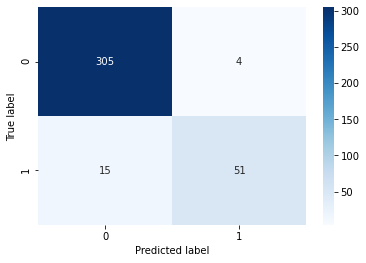

In [146]:
feature_importances_winwin = classifiers.rf_classifier(df, "WINWIN", hide_cols)

In [147]:
feature_importances_winwin = classifiers.sort_feature_importances(feature_importances_winwin)
feature_importances_winwin.head(10)

,features,coefficients,std
0,RQ_JOINT,0.192075,0.004804
1,FT_RA,0.083179,0.002928
2,LP_BI,0.070535,0.003694
3,FT_RD,0.067605,0.002675
4,FT_CC,0.064091,0.002461
5,PLAIN_ML,0.061086,0.004237
6,LP_BI_b,0.053047,0.002968
7,FT_CC_b,0.049656,0.001210
8,FT_RA_b,0.035013,0.002565
9,RQ_MP_SP,0.033248,0.002621


<div class="alert alert-block alert-warning col-md-12">

<p>
The classifier with highest balanced accuracy for prediction the judicial decision is the Random Forest classifier. Is has arround 88% of balanced accuracy, and it performs better in predicting label 1 than predicting label 0, which can probably be explained by the fact that the distribution in the dataset between winning and losing cases is 82.22% - 17.78%. <br><br>
    
We can also see, that the most important feature in predicting the WINWIN label is the RQ_JOINT, which represents whether the plaintiff has requested joint or sole custody. As we saw before, the percentages of joint custody request winning cases and sole custody request winning cases is 21.34% - 13.53%. <br><br>

The other top 5 features that are used when predicting the WINWIN chances are: Parents' relationship and attitude (FT_RA), Best interests of the child (LP_BI), Parents' readiness (FT_RD), Circumstances of children (FT_CC).<br><br>

Finally, we can see that the standard deviation of a feature importance is small, which means that the values varies little between data partitions when using cross-validation. Thus, it does not depend much on the partition and the values are more reliable.
    
</p>

</div>

### Judicial decision prediction model - no plaintiff gender

In [148]:
hide_cols_plaitiff_gender = hide_cols + ["PLAIN_ML"]

Balanced accuracy mean: 0.8814835468757061


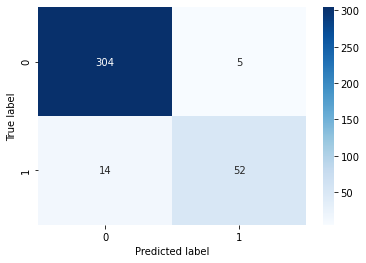

In [149]:
feature_importances_winwin_no_plaintiff_gender = classifiers.rf_classifier(df, "WINWIN", hide_cols_plaitiff_gender)

### Judicial decision prediction model - no judge gender

In [150]:
hide_cols_judge_gender = hide_cols + ["JUDGE_ML"]

Balanced accuracy mean: 0.8859622027663125


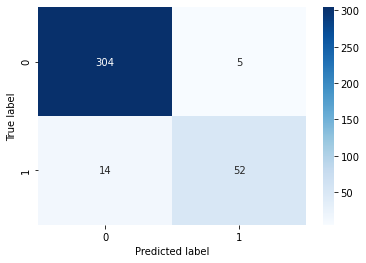

In [151]:
feature_importances_winwin_no_judge_gender = classifiers.rf_classifier(df, "WINWIN", hide_cols_judge_gender)

<div class="alert alert-block alert-warning col-md-12">

<p>
When training the classifier without the gender features, we can conclude that the gender features do not have crucial importance for the model to learn. In both cases (removing the plaintiff gender and removing the judge gender), the accuracy with and without the gender feature is practically the same. Thus, no direct effect of the gender variables is found with this analysis. <br>

</p>
</div>

## Plaintiff gender prediction model

<div class="alert alert-block alert-info col-md-12">

<p>
Can we predict the gender of the plaintiff based on the sentence features with sufficient accuracy?
</p>

</div>

In [152]:
classifiers_comparison.model_comparison(df, "PLAIN_ML", hide_cols)

LogReg - 0.850
RandomForest - 0.826
SVM linear - 0.843
SVM RBF kernel - 0.843
AdaBoost - 0.801


Balanced accuracy mean: 0.8500247637179073


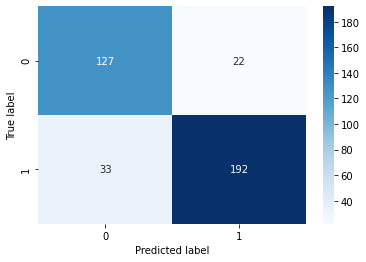

In [153]:
feature_importances_plain = classifiers.lr_classifier(df, "PLAIN_ML", hide_cols)

In [154]:
feature_importances_plain = classifiers.sort_feature_importances(feature_importances_plain)
print(feature_importances_plain.head())
print(feature_importances_plain.tail())

   features  coefficients       std
0  RQ_JOINT      2.871712  0.102631
1  RQ_MP_SP      0.962368  0.106598
2   FT_PD_b      0.915879  0.121151
3     FT_CR      0.660016  0.205288
4  RQ_FH_SP      0.441485  0.036274
       features  coefficients       std
27        FT_RA     -0.472678  0.229746
28        FT_RD     -0.506807  0.216901
29  LN_JNPREF_b     -0.525729  0.066820
30      FT_RD_b     -0.531659  0.119182
31        LP_BI     -0.967621  0.202619


<div class="alert alert-block alert-warning col-md-12">

<p>
The classifier with highest balanced accuracy for prediction the plaintiff gender is the Logistic Regression classifier. Is has arround 85% of balanced accuracy, which means that there are considerable differences between female and male plaintiff arguments. <br><br>

We can see that the standard deviation of a feature importance is a little bit bigger, which means that the values vary  a bit more between data partitions when using cross-validation. 

</p>

</div>

## Judge gender prediction model

<div class="alert alert-block alert-info col-md-12">

<p>
Can we predict the gender of the judge based on the sentence features with sufficient accuracy?
</p>

</div>

In [155]:
classifiers_comparison.model_comparison(df, "JUDGE_ML", hide_cols)

LogReg - 0.500
RandomForest - 0.508
SVM linear - 0.500
SVM RBF kernel - 0.500
AdaBoost - 0.519


Balanced accuracy mean: 0.5187134413525278


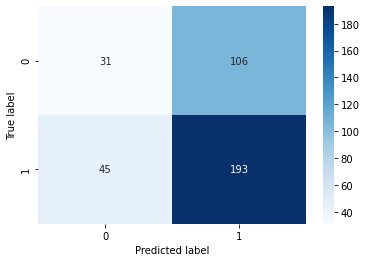

In [156]:
feature_importances_judge = classifiers.ab_classifier(df, "JUDGE_ML", hide_cols)

In [157]:
feature_importances_judge = classifiers.sort_feature_importances(feature_importances_judge)
feature_importances_judge.head()

,features,coefficients,std
0,FT_RD,0.268,0.037191
1,FT_RA,0.223,0.032239
2,LP_BI,0.164,0.031263
3,FT_CR,0.119,0.038182
4,FT_CC,0.059,0.013618


<div class="alert alert-block alert-warning col-md-12">

<p>
The classifier with highest balanced accuracy for prediction the plaintiff gender is the AdaBoost classifier. Is has arround 52% of balanced accuracy. There are no sufficient diferences between female and male judges for the model to be able to predict that label. 
    
</p>

</div>

## Plaintiff gender disparities

<div class="alert alert-block alert-info col-md-12">

<p>

What are the differences between female and male plaintiffs when predicting the winning chances?

</p>

</div>

In [158]:
df_female_plaintiff, df_male_plaintiff = base_rates.df_by_group(df, "PLAIN_ML")

Balanced accuracy mean: 0.8241568509010371


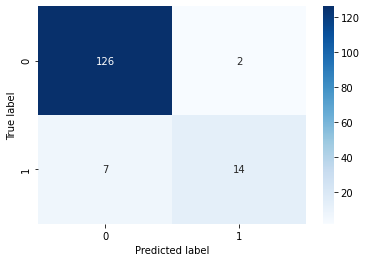

In [159]:
feature_importances_plain_female = classifiers.rf_classifier(df_female_plaintiff, "WINWIN", hide_cols)

Balanced accuracy mean: 0.8784184749246003


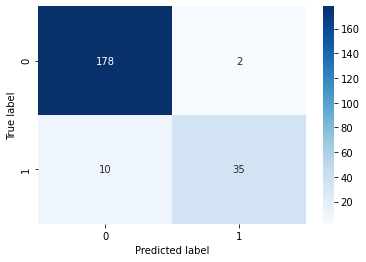

In [160]:
feature_importances_plain_male = classifiers.rf_classifier(df_male_plaintiff, "WINWIN", hide_cols)

In [161]:
df_disp_score_plain = disparity_score.disp_score_feature_importance(feature_importances_plain_female, feature_importances_plain_male)
df_disp_score_plain_above_thres = disparity_score.disp_score_feature_importance_show_above_threshold(df_disp_score_plain)
df_disp_score_plain_above_thres

,features,coefficients_x,coefficients_y,disp_score
2,FT_CC,0.083524,0.059293,0.024231
3,RQ_MP_AT,0.041435,0.018496,0.022938
4,FT_PD,0.038917,0.020937,0.017980
6,LP_BI,0.092159,0.076324,0.015835
7,FT_RD,0.096714,0.083222,0.013492
8,FT_CC_b,0.061487,0.049514,0.011973
9,FT_PD_b,0.026711,0.014786,0.011925
10,FT_CW,0.036660,0.025454,0.011206


In [162]:
df_disp_score_by_category_plain = disparity_score_by_category.create_categories_score_df(df_disp_score_plain)
df_disp_score_by_category_plain

,category,coefficients_x_mean,coefficients_y_mean,disp_score_mean
0,Economical aspects,0.072505,0.054404,0.018102
1,Legal principles (general),0.032928,0.040025,-0.007097
2,Subjectivity (children),0.022041,0.019202,0.002839
3,"Personal circumstances (parents, children)",0.037079,0.034716,0.002362
4,Procesal (economia del procedimiento),0.039232,0.036892,0.002339
5,Personal circumstances (children),0.018121,0.016236,0.001886
6,Subjectivity (parents),0.002318,0.003986,-0.001668


<div class="alert alert-block alert-warning col-md-12">

<p>

We can observe that there are some differences in the arguments (above threshold 0.01). This suggests that there are relevant differences across genders in the features that are used to decide the winning label.
    
</p>

</div>

## Judge gender disparities

In [163]:
df_female_judge, df_male_judge = base_rates.df_by_group(df, "JUDGE_ML")

Balanced accuracy mean: 0.8768804874341096


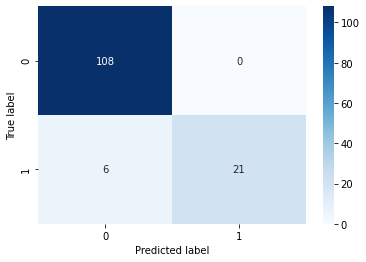

In [164]:
feature_importances_judge_female = classifiers.rf_classifier(df_female_judge, "WINWIN", hide_cols)

Balanced accuracy mean: 0.8390369005176547


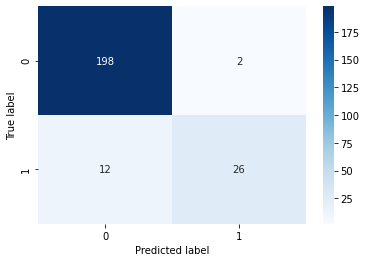

In [165]:
feature_importances_judge_male = classifiers.rf_classifier(df_male_judge, "WINWIN", hide_cols)

In [166]:
df_disp_score_judge = disparity_score.disp_score_feature_importance(feature_importances_judge_female, feature_importances_judge_male)
df_disp_score_judge_above_thres = disparity_score.disp_score_feature_importance_show_above_threshold(df_disp_score_judge, threshold = 0.005)
df_disp_score_judge_above_thres

,features,coefficients_x,coefficients_y,disp_score
0,FT_CC,0.070825,0.057496,0.013329
1,RQ_MP_AT,0.036796,0.027499,0.009297
2,FT_PD,0.031432,0.022168,0.009264
5,FT_CR,0.030560,0.022390,0.008170
6,FT_AG,0.014506,0.007309,0.007196
11,FT_CC_b,0.051125,0.045913,0.005213


In [167]:
df_disp_score_by_category_judge = disparity_score_by_category.create_categories_score_df(df_disp_score_judge)
df_disp_score_by_category_judge

,category,coefficients_x_mean,coefficients_y_mean,disp_score_mean
0,Legal principles (general),0.060975,0.051704,0.009271
1,Subjectivity (children),0.031814,0.034569,-0.002755
2,Procesal (economia del procedimiento),0.023695,0.021393,0.002302
3,"Personal circumstances (parents, children)",0.029975,0.032241,-0.002265
4,Subjectivity (parents),0.002999,0.005100,-0.002101
5,Economical aspects,0.031941,0.030272,0.001668
6,Personal circumstances (children),0.018496,0.018624,-0.000128


<div class="alert alert-block alert-warning col-md-12">

<p>
    
For the judge gender comparison, the differences are not as remarkable as in the plaintiff case. The only feature that is above 0.01 is the circumstances of the children (fact), which is more important when having a female judge.

</p>

</div>

<div class="alert alert-block alert-success col-md-12">

<p>
    
From the classification models section, we can conclude that no direct effects of the gender features are found, but there are significant differences when comparing cases with male and female plaintiffs. The classifier for the plaintiff gender has a high accuracy and also differences in the arguments used for each gender are found.

</p>

</div>

# Propensity score

<div class="alert alert-block alert-info col-md-12">

<p>
Are cases with more winning probability also more prone to belong to males?
</p>

</div>

In [168]:
df_request_sole, df_request_joint = base_rates.df_by_group(df, "RQ_JOINT")

Dimensions:
- X are the underlying characteristics/features available.
- T is the treatment; can be either 1 or 0. Here being a male plaintiff is as T=1 (i.e. the plaintiff got treated).
- Y is the outcome variable WINWIN.

Propensity score is the estimated probability that a subject is treated given certain observable characteristics X. In probability notation this is P(T=1|X).

## Propensity Score Estimation

- T = being a male
- Y = winning
- X = arguments
- ps = probability of being a male

In [169]:
hide_cols = categorical_features + ["PLAIN_ML", "DEFEN_ML"] + features_classification_lists["Court decisions"] + ["JUDGE_ML"]
print(hide_cols)

['ID', 'URL', 'DATE', 'YEAR', 'HQ', 'AUT_COMM', 'JUDGE_ID', 'PLAIN_ML', 'DEFEN_ML', 'CD_JOINT', 'CD_JO_CF', 'WIN_SL', 'WINWIN', 'CD_FH_AT', 'CD_FH_SP', 'CD_MP_AT', 'CD_MP_SP', 'JUDGE_ML']


In [170]:
df_conf = probabilities.lr_classifier_conf(df, "PLAIN_ML", hide_cols)
df_conf = probabilities.conf_by_index(df_conf)
df_conf.head()

Balanced accuracy mean: 0.8500247637179073


,test_index,conf_1
0,0,0.934039
1,1,0.890319
2,2,0.973264
3,3,0.961114
4,4,0.874928


In [171]:
df_ps = pd.DataFrame(list(zip(df["PLAIN_ML"], df["WINWIN"], df_conf["conf_1"])), columns =["PLAIN_ML", "WINWIN", "propensity_score"])
df_ps.head()

,PLAIN_ML,WINWIN,propensity_score
0,1,0,0.934039
1,1,0,0.890319
2,1,0,0.973264
3,1,0,0.961114
4,1,0,0.874928


Text(0.5, 1.0, 'Confounding Evidence')

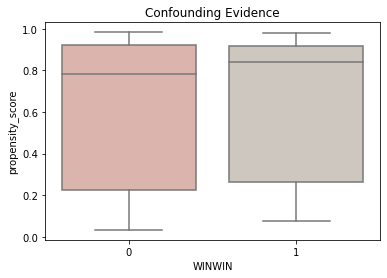

In [172]:
# Cases that win, have more probability (propensity score) of having a male plaintiff
sns.boxplot(x="WINWIN", y="propensity_score", data=df_ps, palette=["#e2b0a6","#d0c7bd"])
plt.title("Confounding Evidence")

<div class="alert alert-block alert-warning col-md-12">

<p>
    
We can see that in the winning cases, the probability of being a male is slightly higher. Which means that some confounding evidence is found.
    
</p>

</div>

## Propensity score aproximation for the outcome variable: sole custody

- T = winning
- Y = --
- X = arguments
- ps = probability of winning

In [174]:
hide_cols = categorical_features + ["PLAIN_ML", "DEFEN_ML"] + features_classification_lists["Court decisions"] + ["JUDGE_ML"]
print(hide_cols)

['ID', 'URL', 'DATE', 'YEAR', 'HQ', 'AUT_COMM', 'JUDGE_ID', 'PLAIN_ML', 'DEFEN_ML', 'CD_JOINT', 'CD_JO_CF', 'WIN_SL', 'WINWIN', 'CD_FH_AT', 'CD_FH_SP', 'CD_MP_AT', 'CD_MP_SP', 'JUDGE_ML']


In [175]:
df_conf_winwin_sole = probabilities.rf_classifier_conf(df_request_sole, "WINWIN", hide_cols)
df_conf_winwin_sole = probabilities.conf_by_index(df_conf_winwin_sole)
df_conf_winwin_sole.head()

Balanced accuracy mean: 0.872045692542587


,test_index,conf_1
0,0,0.073
1,1,0.000
2,2,0.000
3,3,0.001
4,4,0.001


### Confounding evidence

#### Plaintiff gender

In [176]:
df_ps_plain_sole = pd.DataFrame(list(zip(df_request_sole["PLAIN_ML"], df_request_sole["WINWIN"], df_conf_winwin_sole["conf_1"])), columns =["PLAIN_ML", "WINWIN", "conf_1"])
df_ps_plain_sole.head()

,PLAIN_ML,WINWIN,conf_1
0,1,0,0.073
1,0,0,0.000
2,0,0,0.000
3,0,0,0.001
4,0,0,0.001


In [177]:
plain_male_percentage_sole = propensity_score.get_male_percentages(df_ps_plain_sole, "PLAIN_ML", 3)

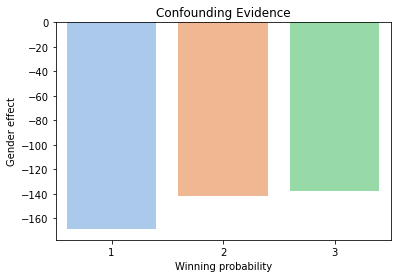

In [178]:
propensity_score.counfounding_plot(plain_male_percentage_sole, 3)

In [179]:
table_propensity_score_gender_effect.create_table_3_buckets(df_ps_plain_sole, "PLAIN_ML")

Propensity score bucket      Male    Female    Effect
-------------------------  ------  --------  --------
Low                            58       227      -169
Medium                         71       213      -142
High                           73       211      -138


<div class="alert alert-block alert-warning col-md-12">

<p>
    
We can observe that no effect or pattern is found in terms of the relationship between the winning probability and the male rate.     
</p>

</div>

#### Judge gender

In [180]:
df_ps_judge_sole = pd.DataFrame(list(zip(df_request_sole["JUDGE_ML"], df_request_sole["WINWIN"], df_conf_winwin_sole["conf_1"])), columns =["JUDGE_ML", "WINWIN", "conf_1"])
df_ps_judge_sole.head()

,JUDGE_ML,WINWIN,conf_1
0,1,0,0.073
1,1,0,0.000
2,0,0,0.000
3,1,0,0.001
4,1,0,0.001


In [181]:
judge_male_percentage_sole = propensity_score.get_male_percentages(df_ps_judge_sole, "JUDGE_ML", 3)

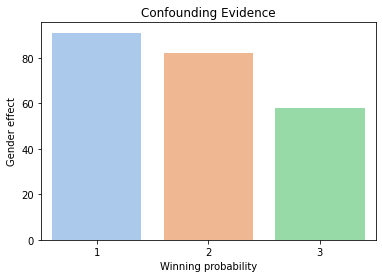

In [182]:
propensity_score.counfounding_plot(judge_male_percentage_sole, 3)

In [183]:
table_propensity_score_gender_effect.create_table_3_buckets(df_ps_judge_sole, "JUDGE_ML")

Propensity score bucket      Male    Female    Effect
-------------------------  ------  --------  --------
Low                           188        97        91
Medium                        183       101        82
High                          171       113        58


<div class="alert alert-block alert-warning col-md-12">

<p>
    
We can see that for cases with higher probability of winning, more females are involved.
    
</p>

</div>

## Propensity score aproximation for the outcome variable: joint custody

- T = winning
- Y = --
- X = arguments
- ps = probability of winning

In [184]:
hide_cols = categorical_features + ["PLAIN_ML", "DEFEN_ML"] + features_classification_lists["Court decisions"] + ["JUDGE_ML"]
print(hide_cols)

['ID', 'URL', 'DATE', 'YEAR', 'HQ', 'AUT_COMM', 'JUDGE_ID', 'PLAIN_ML', 'DEFEN_ML', 'CD_JOINT', 'CD_JO_CF', 'WIN_SL', 'WINWIN', 'CD_FH_AT', 'CD_FH_SP', 'CD_MP_AT', 'CD_MP_SP', 'JUDGE_ML']


In [185]:
df_conf_winwin_joint = probabilities.rf_classifier_conf(df_request_joint, "WINWIN", hide_cols)
df_conf_winwin_joint = probabilities.conf_by_index(df_conf_winwin_joint)
df_conf_winwin_joint.head()

Balanced accuracy mean: 0.9333204230443494


,test_index,conf_1
0,0,0.000
1,1,0.841
2,2,0.146
3,3,0.000
4,4,0.000


### Confounding evidence

#### Plaintiff gender

In [186]:
df_ps_plain_joint = pd.DataFrame(list(zip(df_request_joint["PLAIN_ML"], df_request_joint["WINWIN"], df_conf_winwin_joint["conf_1"])), columns =["PLAIN_ML", "WINWIN", "conf_1"])
df_ps_plain_joint.head()

,PLAIN_ML,WINWIN,conf_1
0,1,0,0.000
1,1,0,0.841
2,1,0,0.146
3,1,0,0.000
4,1,0,0.000


In [187]:
plain_male_percentage_joint = propensity_score.get_male_percentages(df_ps_plain_joint, "PLAIN_ML", 3)

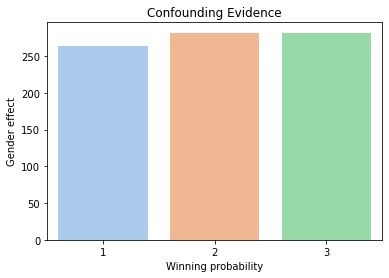

In [188]:
propensity_score.counfounding_plot(plain_male_percentage_joint, 3)

In [189]:
table_propensity_score_gender_effect.create_table_3_buckets(df_ps_plain_joint, "PLAIN_ML")

Propensity score bucket      Male    Female    Effect
-------------------------  ------  --------  --------
Low                           304        40       264
Medium                        313        31       282
High                          312        31       281


<div class="alert alert-block alert-warning col-md-12">

<p>
    
A small effect can be observed, but no clear conclusions can be extracted.    
</p>

</div>

#### Judge gender

In [190]:
df_ps_judge_joint = pd.DataFrame(list(zip(df_request_joint["JUDGE_ML"], df_request_joint["WINWIN"], df_conf_winwin_joint["conf_1"])), columns =["JUDGE_ML", "WINWIN", "conf_1"])
df_ps_judge_joint.head()

,JUDGE_ML,WINWIN,conf_1
0,1,0,0.000
1,1,0,0.841
2,1,0,0.146
3,0,0,0.000
4,1,0,0.000


In [191]:
judge_male_percentage_joint = propensity_score.get_male_percentages(df_ps_judge_joint, "JUDGE_ML", 3)

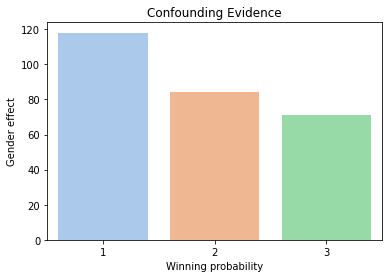

In [192]:
propensity_score.counfounding_plot(judge_male_percentage_joint, 3)

In [193]:
table_propensity_score_gender_effect.create_table_3_buckets(df_ps_judge_joint, "JUDGE_ML")

Propensity score bucket      Male    Female    Effect
-------------------------  ------  --------  --------
Low                           231       113       118
Medium                        214       130        84
High                          207       136        71


<div class="alert alert-block alert-warning col-md-12">

<p>
    
We can observe the same pattern as in the sole custody judge analysis, but with a much more noticeable pattern.
    
</p>

</div>

<div class="alert alert-block alert-success col-md-12">

<p>
    
No pattern is found when analysing the number of male plaintiffs related to the winning probabilty. However, a clear pattern is observed when analysing the number of male judges. For cases with higher probability of winning, more female judges are involved.

</p>

</div>

# Exact matching

<div class="alert alert-block alert-info col-md-12">

<p>
    
Is the probability of winning related the plaintiff gender?
    
</p>

</div>

In [194]:
df_request_sole, df_request_joint = base_rates.df_by_group(df, "RQ_JOINT")

## Request sole

In [199]:
epsilon_sole = 1.5

### Divide by judge id

Use judge_id as instrumental variable:
    - JUDGE_ID even -> group 0 (A)
    - JUDGE_ID uneven -> group 1 (B)

We assume that the judge id is random. 

In [200]:
def divide_by_judge_id(df):
    
    # Split df
    df_A = df.loc[(df['JUDGE_ID'] % 2) == 0]
    df_B = df.loc[(df['JUDGE_ID'] % 2) != 0]
    
    # Check correctly splitted
    print("Size group A (even judge id): " +  str(df_A.shape[0]))
    print("Size group B (odd judge id): " +  str(df_B.shape[0]))
    
    if df.shape[0] == (df_A.shape[0] + df_B.shape[0]):
        print("Correclty splitted")

    return df_A, df_B

In [201]:
df_A_sole, df_B_sole = divide_by_judge_id(df_request_sole)

Size group A (even judge id): 425
Size group B (odd judge id): 428
Correclty splitted


### Create pairs

- For each x, with male plaintiff, in A:
    - Find element y, with female plaintiff, in B that minimizes d(x, y) --> closest element in other group with different plaintiff gender. d(x,y) cannot consider neither the gender nor the judge id
    - If d(x,y) < epsilon, accept the pair (x,y), if not, reject
    
where d(x,y)
- Distance 1: Eclidean distance for all variables except the plaintiff gender and the judge id
- Distance 2: Euclidean distance on a selection of few variables (except the plaintiff gender and the judge id) which have more importance in the winning probability
- Distance 3: Euclidean distance (except the plaintiff gender and the judge id) with weights proportional to the importance of each variable in the model that predicts the probability of winning
- Distance 4: Probability of winning, using all variables except the plaintiff gender and the judge id

#### Precomputations

##### Random sample

Get a random sample of group A and B.

In [202]:
# Get a random sample from group A and B
#df_A_sole_sample = df_A_sole.sample(frac=0.5, random_state=1)
#df_B_sole_sample = df_B_sole.sample(frac=0.5, random_state=1)
df_A_sole_sample = df_A_sole
df_B_sole_sample = df_B_sole
print("Size random sample A: " + str(df_A_sole_sample.shape[0]))
print("Size random sample B: " + str(df_B_sole_sample.shape[0]))

Size random sample A: 425
Size random sample B: 428


##### Most important vars and its weights

In [203]:
# Get the top 10 features (based on feature importance) and its weights (based on the model coefficients)
feature_weights_top_10_sole = precomputations.get_top_10_vars_and_wights_winwin(df_request_sole)
feature_weights_top_10_sole

Removing 'JUDGE_ID' from the dict


{'FT_CC': 0.1269541031589519,
 'LP_BI': 0.12640946865514782,
 'FT_CC_b': 0.11868615284695348,
 'LP_BI_b': 0.10362660226511498,
 'FT_RA': 0.07883269443419123,
 'FT_RD': 0.06968169192933543,
 'FT_RA_b': 0.05293056902094074,
 'FT_CW': 0.03378409344658404,
 'FT_PD': 0.0290873112340755}

In [204]:
# Save into file
with open("../output/feature_weights_top_10_sole.json", "w") as outfile:
    json.dump(feature_weights_top_10_sole, outfile)

##### Probability of winning

In [205]:
prob_winning = precomputations.prob_winning(df)
prob_winning

Balanced accuracy mean: 0.8591429947038998


,test_index,conf_1
0,0,0.192
1,1,0.698
2,2,0.337
3,3,0.203
4,4,0.162
...,...,...
1879,1879,0.626
1880,1880,0.358
1881,1881,0.330
1882,1882,0.010


In [206]:
prob_winning.to_csv("..\output\prob_winning.csv", sep=";", index=False)

##### Distances (to choose epsilon)

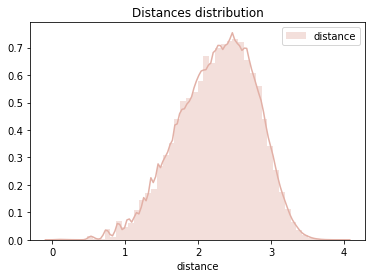

In [207]:
distances_df = pd.read_csv("..\output\distances.csv", sep=";")
distances.distances_plot(distances_df)

#### Euclidean (all variables)

Eclidean distance for all variables except the plaintiff gender and the judge id

In [208]:
pairs_all = get_pairs.get_pairs(df_A_sole_sample, df_B_sole_sample, get_distances.euclidean_distance_all, epsilon_sole)
pairs_all

,index_1,index_2,dist
0,21,574,0.904
1,23,795,1.330
2,30,1079,1.433
3,42,1249,1.172
4,45,1158,0.062
...,...,...,...
85,1824,1477,0.547
86,1827,491,0.717
87,1872,1333,0.723
88,1876,362,0.909


#### Euclidean (most important variables)

Euclidean distance on a selection of few variables (except the plaintiff gender and the judge id) which have more importance in the winning probability (based on feature importance)

In [209]:
pairs_imp_vars = get_pairs.get_pairs(df_A_sole_sample, df_B_sole_sample, get_distances.euclidean_distance_most_imp_vars, epsilon_sole)
pairs_imp_vars

,index_1,index_2,dist
0,21,1501,0.090
1,23,114,0.064
2,30,1075,0.084
3,42,1333,0.051
4,45,364,0.031
...,...,...,...
85,1824,252,0.105
86,1827,25,0.084
87,1872,910,0.031
88,1876,981,0.085


#### Euclidean (with weights) 

Euclidean distance (except the plaintiff gender and the judge id) with weights proportional to the importance of each variable in the model that predicts the probability of winning

In [210]:
pairs_with_weights = get_pairs.get_pairs(df_A_sole_sample, df_B_sole_sample, get_distances.euclidean_distance_with_weights, epsilon_sole)
pairs_with_weights

,index_1,index_2,dist
0,21,80,0.024
1,23,114,0.013
2,30,1075,0.019
3,42,1048,0.014
4,45,364,0.008
...,...,...,...
85,1824,252,0.032
86,1827,25,0.019
87,1872,910,0.008
88,1876,251,0.017


#### Probability of winning

Probability of winning, using all variables except the plaintiff gender and the judge id

In [211]:
pairs_probability_of_winning = get_pairs.get_pairs(df_A_sole_sample, df_B_sole_sample, get_distances.distance_probability_of_winning, epsilon_sole)
pairs_probability_of_winning

,index_1,index_2,dist
0,21,167,0.001
1,23,114,0.008
2,30,229,0.001
3,42,230,0.001
4,45,185,0.002
...,...,...,...
85,1824,1228,0.001
86,1827,1055,0.001
87,1872,837,0.001
88,1876,721,0.000


### Gender effect

In [213]:
gender_effect_all = gender_effect.gender_effect(df, pairs_all)
gender_effect_all

0.02222

In [214]:
gender_effect_imp_vars = gender_effect.gender_effect(df, pairs_imp_vars)
gender_effect_imp_vars

0.01111

In [215]:
gender_effect_with_weights = gender_effect.gender_effect(df, pairs_with_weights)
gender_effect_with_weights

0.01111

In [216]:
gender_effect_probability_of_winning = gender_effect.gender_effect(df, pairs_probability_of_winning)
gender_effect_probability_of_winning

-0.01111

## Request joint

In [217]:
epsilon_joint = 0.75

### Divide by judge id

In [218]:
df_A_joint, df_B_joint = divide_by_judge_id(df_request_joint)

Size group A (even judge id): 487
Size group B (odd judge id): 544
Correclty splitted


### Create pairs

#### Precomputations

In [219]:
# Get the top 10 features (based on feature importance) and its weights (based on the model coefficients)
feature_weights_top_10_joint = precomputations.get_top_10_vars_and_wights_winwin(df_request_joint)
feature_weights_top_10_joint

Removing 'JUDGE_ID' from the dict


{'LP_BI': 0.15870560491634741,
 'LP_BI_b': 0.14757867625123805,
 'FT_RA': 0.1420749622081764,
 'FT_CC': 0.09496853601931926,
 'FT_CC_b': 0.08824065492010755,
 'FT_RA_b': 0.07099258362406634,
 'FT_RD': 0.057275220370245954,
 'FT_RD_b': 0.030793419908473098,
 'FT_CW': 0.020926330846021683}

In [220]:
# Save into file
with open("../output/feature_weights_top_10_joint.json", "w") as outfile:
    json.dump(feature_weights_top_10_joint, outfile)

#### Euclidean (all variables)

In [221]:
pairs_all_joint = get_pairs.get_pairs(df_A_joint, df_B_joint, get_distances.euclidean_distance_all, epsilon_joint)
pairs_all_joint

,index_1,index_2,dist
0,27,770,0.731
1,37,214,0.517
2,112,71,0.577
3,130,1418,0.639
4,184,669,0.570
...,...,...,...
91,1833,1418,0.590
92,1834,669,0.540
93,1841,770,0.527
94,1850,770,0.534


#### Euclidean (most important variables)

In [222]:
pairs_imp_vars_joint = get_pairs.get_pairs(df_A_joint, df_B_joint, get_distances.euclidean_distance_most_imp_vars, epsilon_joint)
pairs_imp_vars_joint

,index_1,index_2,dist
0,0,322,0.045
1,3,1324,0.080
2,5,669,0.170
3,8,1608,0.031
4,10,716,0.570
...,...,...,...
431,1858,716,0.194
432,1866,716,0.286
433,1868,322,0.040
434,1870,716,0.312


#### Euclidean (with weights)

In [223]:
pairs_with_weights_joint = get_pairs.get_pairs(df_A_joint, df_B_joint, get_distances.euclidean_distance_with_weights, epsilon_joint)
pairs_with_weights_joint.head()

,index_1,index_2,dist
0,0,322,0.014
1,3,1324,0.032
2,5,669,0.025
3,8,1608,0.007
4,10,716,0.135


#### Probability of winning

In [224]:
pairs_probability_of_winning_joint = get_pairs.get_pairs(df_A_joint, df_B_joint, get_distances.distance_probability_of_winning, epsilon_joint)
pairs_probability_of_winning_joint.head()

,index_1,index_2,dist
0,0,1747,0.000
1,3,1695,0.002
2,5,322,0.017
3,8,1809,0.001
4,10,259,0.007


### Gender effect

In [225]:
gender_effect_all_joint = gender_effect.gender_effect(df, pairs_all_joint)
gender_effect_all_joint

-0.03125

In [226]:
gender_effect_imp_vars_joint = gender_effect.gender_effect(df, pairs_imp_vars_joint)
gender_effect_imp_vars_joint

0.01835

In [227]:
gender_effect_with_weights_joint = gender_effect.gender_effect(df, pairs_with_weights_joint)
gender_effect_with_weights_joint

0.01606

In [228]:
gender_effect_probability_of_winning_joint = gender_effect.gender_effect(df, pairs_probability_of_winning_joint)
gender_effect_probability_of_winning_joint

0.0

<div class="alert alert-block alert-success col-md-12">

<p>
    
Differences in all cases are quite small, for both custody types. Thus, from this analysis we could conclude that that is no effect on the outcome variable - winning label - coming from the treatment - being a male -.    
</p>

</div>